In [1]:
# Data handling
import pandas as pd
import numpy as np
import networkx as nx
import json
from pyvis.network import Network
from datetime import datetime
import math

# Model building
from scipy.cluster.hierarchy import dendrogram, linkage
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

# Metrics
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error, r2_score

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import matplotlib.image as mpimg
import matplotlib.colors as mcolors

In [2]:
# import data
nyc_df = pd.read_csv('Bike-NYC.csv')

In [3]:
# assign time label

# start
series = nyc_df['starttime'].map(lambda x:datetime.strptime(x, '%m/%d/%Y %H:%M'))
time_df = pd.DataFrame({'starttime': series})
time_df['day'] = time_df['starttime'].map(lambda x:x.day)
time_df['start_hour'] = time_df['starttime'].map(lambda x:x.hour)
time_df['year'] = time_df['starttime'].map(lambda x:x.year)
time_df['weekday'] = time_df['starttime'].map(lambda x:x.weekday())

# end
series = nyc_df['stoptime'].map(lambda x:datetime.strptime(x, '%m/%d/%Y %H:%M'))
time_df['end_hour'] = pd.DataFrame({'stoptime': series})['stoptime'].map(lambda x:x.hour)

# total demand
by_hour = time_df.groupby(['day','start_hour'])

In [4]:
# combine time label back to the original df
nyc_df = pd.concat([time_df,nyc_df], axis=1)

In [5]:
# check if the start station and end stations are the same
pd.DataFrame(np.sort(nyc_df['end station id'])==np.sort(nyc_df['start station id']))

,0
0,True
1,True
2,True
3,True
4,True
...,...
473615,True
473616,True
473617,True
473618,True


In [6]:
# network preparation
link = pd.DataFrame(nyc_df[['start station id','end station id']].groupby(['start station id','end station id']).size()).reset_index()
link.columns=['start','end','weight']
link

,start,end,weight
0,72,72,76
1,72,79,2
2,72,82,5
3,72,116,3
4,72,127,7
...,...,...,...
60521,3002,2009,2
60522,3002,2010,8
60523,3002,2012,6
60524,3002,2021,2


In [7]:
# create a net object
net= nx.from_pandas_edgelist(link, source='start', target='end', edge_attr='weight', create_using=nx.DiGraph())

In [8]:
# construct the dataframe that documents the different degrees of the network
nodes_data = pd.DataFrame({
    "name": list(net.nodes()),
    "degree": list(dict(net.degree()).values()),
    "weighted_in_degree": list(dict(net.in_degree(weight='weight')).values()),
    "weighted_out_degree": list(dict(net.out_degree(weight='weight')).values()),
    "weighted_degree": list(dict(net.degree(weight='weight')).values())
})
nodes_data

,name,degree,weighted_in_degree,weighted_out_degree,weighted_degree
0,72,414,1627,1582,3209
1,79,399,1261,1205,2466
2,82,290,589,607,1196
3,116,459,2600,2511,5111
4,127,467,2565,2459,5024
...,...,...,...,...,...
320,2005,32,33,36,69
321,393,365,879,842,1721
322,2017,311,658,673,1331
323,431,104,128,137,265


In [9]:
# Create adjacency matrix as a DataFrame
adj_matrix = nx.to_pandas_adjacency(net)

# Replace NaN values with zeros (nodes with no connection)
adj_matrix.fillna(0, inplace=True)
adj_matrix = adj_matrix.astype(int)
adj_matrix

,72,79,82,116,127,128,137,146,147,151,...,164,266,339,119,373,2005,393,2017,431,443
72,76,2,5,3,7,3,5,2,12,2,...,0,0,0,0,0,0,0,0,0,0
79,6,28,0,10,19,12,1,31,48,22,...,0,0,0,0,0,0,0,0,0,0
82,0,1,34,0,0,0,0,0,1,34,...,0,0,0,0,0,0,0,0,0,0
116,13,3,0,37,9,13,0,2,10,13,...,2,1,2,0,0,0,0,0,0,0
127,17,11,0,31,45,22,0,4,17,33,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
393,0,1,0,3,0,3,1,0,4,5,...,7,3,3,0,0,0,27,2,0,0
2017,0,0,0,0,2,0,3,0,0,0,...,4,3,0,0,0,0,3,7,0,0
431,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,6,0,0,0,5,0


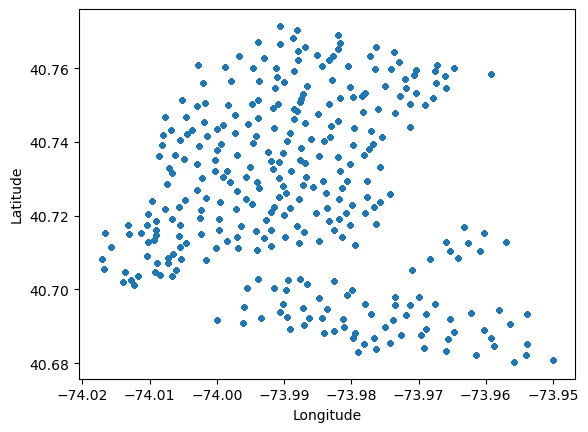

In [10]:
# scatterplot of bike stations
plt.scatter(nyc_df['start station longitude'], nyc_df['start station latitude'],s=10)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [11]:
# preprare cluster input
long_lat = nyc_df[['start station id','start station longitude','start station latitude']].drop_duplicates()
cluster_input = pd.merge(
    long_lat,
    adj_matrix,
    left_on='start station id',
    right_index=True
)
cluster_input.columns = cluster_input.columns.astype(str)
cluster_input

,start station id,start station longitude,start station latitude,72,79,82,116,127,128,137,...,164,266,339,119,373,2005,393,2017,431,443
0,470,-74.000040,40.743453,7,1,0,4,8,1,6,...,2,0,0,0,0,0,0,0,0,0
1,236,-73.987140,40.728419,0,2,2,10,12,22,0,...,6,12,4,0,0,0,20,2,0,1
2,224,-74.005524,40.711464,0,5,7,0,15,6,0,...,0,0,1,0,1,0,1,0,0,0
3,150,-73.980858,40.720874,0,9,0,3,3,5,0,...,8,0,1,0,0,0,4,0,0,0
4,519,-73.978370,40.752416,5,10,2,25,29,24,32,...,14,0,1,0,1,0,1,13,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8246,343,-73.969868,40.697940,0,0,0,0,0,0,0,...,0,0,0,0,5,1,0,0,0,2
10933,2001,-73.979927,40.699773,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
18841,2005,-73.971001,40.705312,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
209288,157,-73.996123,40.690893,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [12]:
# K-mean clustering

# standardize the variables
scaler = StandardScaler()
cluster_input_std = scaler.fit_transform(cluster_input.drop(columns='start station id'))

# set seed
np.random.seed(0)

# Finding optimal K
for i in range (2,10):
    kmeans = KMeans(n_clusters=i)
    model = kmeans.fit(cluster_input_std)
    labels = model.labels_
    print(i,':',silhouette_score(cluster_input_std,labels))

C:\Users\kbzh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\kbzh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


2 : 0.12524382811141527


C:\Users\kbzh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\kbzh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


3 : 0.14014074776676685


C:\Users\kbzh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\kbzh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


4 : 0.13988048153156007


C:\Users\kbzh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\kbzh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


5 : 0.13047845707939715


C:\Users\kbzh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\kbzh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


6 : 0.12912870564796705


C:\Users\kbzh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\kbzh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


7 : 0.10087215744361804


C:\Users\kbzh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\kbzh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


8 : 0.12143429218908554


C:\Users\kbzh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\kbzh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


9 : 0.11424505602340271


In [13]:
# run kmeans with k=3
kmeans = KMeans(n_clusters=3)
model = kmeans.fit(cluster_input_std)
labels = model.labels_

C:\Users\kbzh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\kbzh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


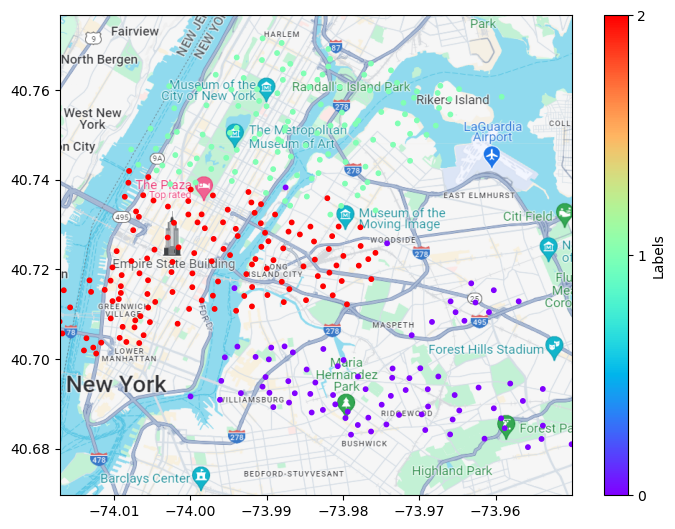

In [14]:
# load the map image
map_img = mpimg.imread('map.png')

# plot with bike stations
plt.imshow(map_img, extent=[-74.01713445, -73.95004798, 40.669602, 40.77668], aspect='auto')
scatter = plt.scatter(cluster_input['start station longitude'], cluster_input['start station latitude'], c=labels, cmap='rainbow', s=10)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

# Create a colormap and normalize it
cmap = plt.cm.rainbow
norm = mcolors.Normalize(vmin=min(labels), vmax=max(labels))

# Add colorbar
cbar = plt.colorbar(mappable=scatter, cmap=cmap, norm=norm, label='Labels')
cbar.set_ticks(range(min(labels), max(labels)+1))  # Set ticks for each label

plt.show()

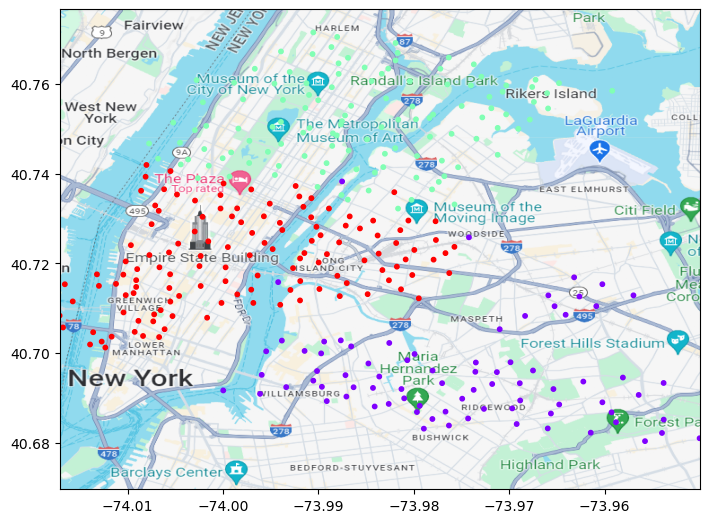

In [15]:
# load the map image
map_img = mpimg.imread('map.png')

# plot with bike stations
plt.imshow(map_img, extent=[-74.01713445, -73.95004798, 40.669602, 40.77668], aspect='auto')
plt.scatter(cluster_input['start station longitude'], cluster_input['start station latitude'], c=labels, cmap='rainbow', s=10)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

In [16]:
nyc_cluster_df = pd.merge(
    nyc_df,
    pd.DataFrame(list(zip(cluster_input['start station id'],np.transpose(labels))), columns = ['start station id','cluster label start']),
    on='start station id'
)
nyc_cluster_df = pd.merge(
    nyc_cluster_df,
    pd.DataFrame(list(zip(cluster_input['start station id'],np.transpose(labels))), columns = ['start station id','cluster label end']),
    left_on='end station id',
    right_on='start station id'
).drop(columns = 'start station id_y')
nyc_cluster_df

,starttime,day,start_hour,year,weekday,end_hour,tripduration,starttime,stoptime,start station id_x,...,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,cluster label start,cluster label end
0,2014-08-01 00:00:00,1,0,2014,4,0,1142,8/1/2014 0:00,8/1/2014 0:19,470,...,312,Allen St & E Houston St,40.722055,-73.989111,19117,Subscriber,1969,1,1,2
1,2014-08-04 18:49:00,4,18,2014,0,19,1111,8/4/2014 18:49,8/4/2014 19:08,470,...,312,Allen St & E Houston St,40.722055,-73.989111,16536,Subscriber,1982,1,1,2
2,2014-08-07 18:00:00,7,18,2014,3,18,1092,8/7/2014 18:00,8/7/2014 18:18,470,...,312,Allen St & E Houston St,40.722055,-73.989111,15319,Subscriber,1984,2,1,2
3,2014-08-01 12:26:00,1,12,2014,4,12,320,8/1/2014 12:26,8/1/2014 12:32,236,...,312,Allen St & E Houston St,40.722055,-73.989111,19505,Subscriber,1989,1,2,2
4,2014-08-01 19:43:00,1,19,2014,4,19,249,8/1/2014 19:43,8/1/2014 19:48,236,...,312,Allen St & E Houston St,40.722055,-73.989111,19778,Subscriber,1970,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473615,2014-08-01 17:59:00,1,17,2014,4,18,1405,8/1/2014 17:59,8/1/2014 18:22,2001,...,2001,Sands St & Navy St,40.699773,-73.979927,20020,Customer,\N,0,0,0
473616,2014-08-01 18:01:00,1,18,2014,4,18,1321,8/1/2014 18:01,8/1/2014 18:23,2001,...,2001,Sands St & Navy St,40.699773,-73.979927,16454,Customer,\N,0,0,0
473617,2014-08-06 14:38:00,6,14,2014,2,14,1176,8/6/2014 14:38,8/6/2014 14:57,2001,...,2001,Sands St & Navy St,40.699773,-73.979927,16031,Subscriber,1982,1,0,0
473618,2014-08-06 15:09:00,6,15,2014,2,15,1621,8/6/2014 15:09,8/6/2014 15:36,2001,...,2001,Sands St & Navy St,40.699773,-73.979927,16414,Subscriber,1982,1,0,0


In [17]:
# the total demand set
vals = by_hour.groups.values()
first_id = list(map(lambda x:x[0],vals))
create = {}
create['entiretraffic'] = list(by_hour.size())
create['datetime']= time_df.loc[first_id, 'starttime']
train_df = pd.DataFrame(create)
train_df['year'] = train_df['datetime'].map(lambda x:x.year)
train_df['month'] = train_df['datetime'].map(lambda x:x.month)
train_df['day'] = train_df['datetime'].map(lambda x:x.day)
train_df['hour'] = train_df['datetime'].map(lambda x:x.hour)
train_df['weekday'] = train_df['datetime'].map(lambda x:x.weekday())
train_df = train_df.drop('datetime', axis=1)
print(train_df.head())

     entiretraffic  year  month  day  hour  weekday
0              393  2014      8    1     0        4
393            171  2014      8    1     1        4
564            126  2014      8    1     2        4
690             53  2014      8    1     3        4
743             69  2014      8    1     4        4


In [18]:
# meterology data
mete_df = pd.read_excel('Meteorology-NYC.xls')
mete_df.columns=['time', 'Temperature ° F', 'Wind Speed mph', 'Weather']
mete_df

,time,Temperature ° F,Wind Speed mph,Weather
0,8-1-2014 0:51 EDT,73.9,3.5,no value
1,8-1-2014 1:51 EDT,73.0,0.0,no value
2,8-1-2014 2:51 EDT,72.0,3.5,no value
3,8-1-2014 3:51 EDT,72.0,3.5,no value
4,8-1-2014 4:51 EDT,71.1,4.6,no value
...,...,...,...,...
444,8-15-2014 19:51 EDT,69.1,9.2,no value
445,8-15-2014 20:51 EDT,69.1,0.0,no value
446,8-15-2014 21:51 EDT,69.1,4.6,no value
447,8-15-2014 22:51 EDT,68.0,0.0,no value


In [19]:
mete_df['datetime'] = mete_df['time'].map(lambda x:datetime.strptime(x.strip(' EDT'), '%m-%d-%Y %H:%M'))
mete_df['year'] = mete_df['datetime'].map(lambda x:x.year)
mete_df['month'] = mete_df['datetime'].map(lambda x:x.month)
mete_df['day'] = mete_df['datetime'].map(lambda x:x.day)
mete_df['hour'] = mete_df['datetime'].map(lambda x:x.hour)
mete_df = mete_df.drop(['time', 'datetime'], axis=1)
mete_df.head()

,Temperature ° F,Wind Speed mph,Weather,year,month,day,hour
0,73.9,3.5,no value,2014,8,1,0
1,73.0,0.0,no value,2014,8,1,1
2,72.0,3.5,no value,2014,8,1,2
3,72.0,3.5,no value,2014,8,1,3
4,71.1,4.6,no value,2014,8,1,4


In [20]:
# check if there's missing data
mete_df.isnull().sum()

Temperature ° F     0
Wind Speed mph     28
Weather             0
year                0
month               0
day                 0
hour                0
dtype: int64

In [21]:
# set NaN to all wind speed rows with 0 value
wind = mete_df[['Wind Speed mph']][:]
wind[wind == 0] = float('nan')
wind.tail()

,Wind Speed mph
444,9.2
445,NaN
446,4.6
447,NaN
448,3.5


In [22]:
# fill na with avg value
forward = wind.fillna(method='ffill')
backward = wind.fillna(method='bfill')
wind = ((forward + backward) / 2)
mete_df['Wind Speed mph'] = wind
wind.tail()

,Wind Speed mph
444,9.20
445,6.90
446,4.60
447,4.05
448,3.50


In [23]:
# check the unique values in Weather
mete_df['Weather'].value_counts().index

Index(['no value', 'lt rain; fog', 'fog', 'mod rain; fog', 'lt rain', 'haze'], dtype='object', name='Weather')

In [24]:
# transform unstructered info
mete_df['weather'] = -1
mete_df.loc[mete_df.Weather == 'no value', 'weather'] = 3
mete_df.loc[mete_df.Weather == 'haze', 'weather'] = 2
mete_df.loc[mete_df.Weather == 'fog', 'weather'] = 2
mete_df.loc[mete_df.Weather == 'lt rain', 'weather'] = 1
mete_df.loc[mete_df.Weather == 'lt rain; fog', 'weather'] = 1
mete_df.loc[mete_df.Weather == 'mod rain; fog', 'weather'] = 1
mete_df = mete_df.drop('Weather', axis=1)

In [25]:
# Note that len(mete_df) = 449 > 15*24=360
# This is because in some hours, there are more one entry.
# e.g. 8-2-2014 5:26, EDT 8-2-2014 5:49, EDT 8-2-2014 5:51 EDT

In [26]:
# remove duplicate rows
tmp = mete_df.groupby(['year', 'month', 'day', 'hour']).mean().reset_index()
tmp['weather'] = mete_df.groupby(['year', 'month', 'day', 'hour']).max().reset_index()['weather']
mete_df = tmp

In [27]:
# transform index back to objects
def map_weather(value):
    if value == 3:
        return 'sunny'
    elif value == 2:
        return 'haze'
    elif value == 1:
        return 'rainy'
    
mete_df['weather'] = mete_df['weather'].apply(map_weather)

In [28]:
# check
mete_df['weather'].value_counts().index

Index(['sunny', 'rainy', 'haze'], dtype='object', name='weather')

In [29]:
# # demand by cluster
demand_agg = pd.DataFrame(nyc_cluster_df.groupby(['day','start_hour','cluster label start','weekday']).size()).reset_index()
demand_agg.columns = ['day','hour','label','weekday','demand']

c1 = demand_agg.query('label == 0').sort_values(by=['day','hour','weekday'])
c2 = demand_agg.query('label == 1').sort_values(by=['day','hour','weekday'])
c3 = demand_agg.query('label == 2').sort_values(by=['day','hour','weekday'])

In [30]:
# merge meterology data back to cluster demand df

# c1
c1 = c1.merge(mete_df, how='left',on=['day','hour'])
c1['isweekend'] = c1['weekday'].map(lambda x:x>4)

# c2
c2 = c2.merge(mete_df, how='left',on=['day','hour'])
c2['isweekend'] = c2['weekday'].map(lambda x:x>4)

# c3
c3 = c3.merge(mete_df, how='left',on=['day','hour'])
c3['isweekend'] = c3['weekday'].map(lambda x:x>4)

In [31]:
def returned_same_hour(df):
    check_out = df['start_hour']
    check_in = df['end_hour']
    if check_out==check_in:
        return True
    elif check_out != check_in:
        return False

nyc_cluster_df['returned_same_hour'] = nyc_cluster_df.apply(returned_same_hour, axis=1)

In [32]:
def returned_same_cluster(df):
    check_out = df['cluster label start']
    check_in = df['cluster label end']
    if check_out==check_in:
        return True
    elif check_out != check_in:
        return False

nyc_cluster_df['returned_same_cluster'] = nyc_cluster_df.apply(returned_same_cluster, axis=1)

In [33]:
# proportion of leaving cluster travel destination

# c1
display(pd.crosstab(index=nyc_cluster_df.query('returned_same_cluster == False and returned_same_hour==False')[nyc_cluster_df['cluster label start']==0]['cluster label end'], columns='count', normalize=True))
display(pd.crosstab(index=nyc_cluster_df.query('returned_same_cluster == False and returned_same_hour==True')[nyc_cluster_df['cluster label start']==0]['cluster label end'], columns='count', normalize=True))

# c2
display(pd.crosstab(index=nyc_cluster_df.query('returned_same_cluster == False and returned_same_hour==False')[nyc_cluster_df['cluster label start']==1]['cluster label end'], columns='count', normalize=True))
display(pd.crosstab(index=nyc_cluster_df.query('returned_same_cluster == False and returned_same_hour==True')[nyc_cluster_df['cluster label start']==1]['cluster label end'], columns='count', normalize=True))

# c3
display(pd.crosstab(index=nyc_cluster_df.query('returned_same_cluster == False and returned_same_hour==False')[nyc_cluster_df['cluster label start']==2]['cluster label end'], columns='count', normalize=True))
display(pd.crosstab(index=nyc_cluster_df.query('returned_same_cluster == False and returned_same_hour==True')[nyc_cluster_df['cluster label start']==2]['cluster label end'], columns='count', normalize=True))

C:\Users\kbzh\AppData\Local\Temp\ipykernel_63284\2683881142.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(pd.crosstab(index=nyc_cluster_df.query('returned_same_cluster == False and returned_same_hour==False')[nyc_cluster_df['cluster label start']==0]['cluster label end'], columns='count', normalize=True))


col_0,count
cluster label end,
1,0.277908
2,0.722092


C:\Users\kbzh\AppData\Local\Temp\ipykernel_63284\2683881142.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(pd.crosstab(index=nyc_cluster_df.query('returned_same_cluster == False and returned_same_hour==True')[nyc_cluster_df['cluster label start']==0]['cluster label end'], columns='count', normalize=True))


col_0,count
cluster label end,
1,0.173576
2,0.826424


C:\Users\kbzh\AppData\Local\Temp\ipykernel_63284\2683881142.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(pd.crosstab(index=nyc_cluster_df.query('returned_same_cluster == False and returned_same_hour==False')[nyc_cluster_df['cluster label start']==1]['cluster label end'], columns='count', normalize=True))


col_0,count
cluster label end,
0,0.068892
2,0.931108


C:\Users\kbzh\AppData\Local\Temp\ipykernel_63284\2683881142.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(pd.crosstab(index=nyc_cluster_df.query('returned_same_cluster == False and returned_same_hour==True')[nyc_cluster_df['cluster label start']==1]['cluster label end'], columns='count', normalize=True))


col_0,count
cluster label end,
0,0.025516
2,0.974484


C:\Users\kbzh\AppData\Local\Temp\ipykernel_63284\2683881142.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(pd.crosstab(index=nyc_cluster_df.query('returned_same_cluster == False and returned_same_hour==False')[nyc_cluster_df['cluster label start']==2]['cluster label end'], columns='count', normalize=True))


col_0,count
cluster label end,
0,0.168746
1,0.831254


C:\Users\kbzh\AppData\Local\Temp\ipykernel_63284\2683881142.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(pd.crosstab(index=nyc_cluster_df.query('returned_same_cluster == False and returned_same_hour==True')[nyc_cluster_df['cluster label start']==2]['cluster label end'], columns='count', normalize=True))


col_0,count
cluster label end,
0,0.117484
1,0.882516


In [34]:
# contingency table

# c1
contingency_c1 = pd.DataFrame(nyc_cluster_df[nyc_cluster_df['cluster label start']==0].groupby(['day','weekday','start_hour']).agg({'returned_same_hour':'sum','returned_same_cluster':'sum','year':'count'})).reset_index()
contingency_c1.columns=['day','weekday','start_hour','returned_same_hour','returned_same_cluster','total']
contingency_c1['isweekend'] = contingency_c1['weekday'].map(lambda x:x>4)

# c2
contingency_c2 = pd.DataFrame(nyc_cluster_df[nyc_cluster_df['cluster label start']==1].groupby(['day','weekday','start_hour']).agg({'returned_same_hour':'sum','returned_same_cluster':'sum','year':'count'})).reset_index()
contingency_c2.columns=['day','weekday','start_hour','returned_same_hour','returned_same_cluster','total']
contingency_c2['isweekend'] = contingency_c2['weekday'].map(lambda x:x>4)

# c3
contingency_c3 = pd.DataFrame(nyc_cluster_df[nyc_cluster_df['cluster label start']==2].groupby(['day','weekday','start_hour']).agg({'returned_same_hour':'sum','returned_same_cluster':'sum','year':'count'})).reset_index()
contingency_c3.columns=['day','weekday','start_hour','returned_same_hour','returned_same_cluster','total']
contingency_c3['isweekend'] = contingency_c3['weekday'].map(lambda x:x>4)

In [35]:
# compute probability hour
contingency_c1.loc[:,'prob_hour'] = contingency_c1['returned_same_hour']/contingency_c1['total']
contingency_c1.loc[:,'prob_cluster'] = contingency_c1['returned_same_cluster']/contingency_c1['total']

contingency_c2.loc[:,'prob_hour'] = contingency_c2['returned_same_hour']/contingency_c2['total']
contingency_c2.loc[:,'prob_cluster'] = contingency_c2['returned_same_cluster']/contingency_c2['total']

contingency_c3.loc[:,'prob_hour'] = contingency_c3['returned_same_hour']/contingency_c3['total']
contingency_c3.loc[:,'prob_cluster'] = contingency_c3['returned_same_cluster']/contingency_c3['total']

In [36]:
# c1
s1_c1_T = pd.DataFrame(nyc_cluster_df[nyc_cluster_df['cluster label start']==0].query('returned_same_hour==True').groupby(['day','weekday','start_hour']).agg({'returned_same_cluster':'sum','year':'count'})).reset_index()
s1_c1_F = pd.DataFrame(nyc_cluster_df[nyc_cluster_df['cluster label start']==0].query('returned_same_hour==False').groupby(['day','weekday','start_hour']).agg({'returned_same_cluster':'sum','year':'count'})).reset_index()

s1_c1_T.loc[:,'P(C|H)']= s1_c1_T['returned_same_cluster']/s1_c1_T['year']
s1_c1_F.loc[:,'P(C|Hc)']= s1_c1_F['returned_same_cluster']/s1_c1_F['year']
s1_c1_T.loc[:,'P(Cc|H)']= 1-(s1_c1_T['returned_same_cluster']/s1_c1_T['year'])
s1_c1_F.loc[:,'P(Cc|Hc)']= 1-(s1_c1_F['returned_same_cluster']/s1_c1_F['year'])

s1_c1_T.loc[:,'P(C∩H)']= s1_c1_T['P(C|H)']*contingency_c1['prob_hour']
s1_c1_F.loc[:,'P(C∩Hc)']= s1_c1_F['P(C|Hc)']*(1-contingency_c1['prob_hour'])
s1_c1_T.loc[:,'P(Cc∩H)']= s1_c1_T['P(Cc|H)']*contingency_c1['prob_hour']
s1_c1_F.loc[:,'P(Cc∩Hc)']= s1_c1_F['P(Cc|Hc)']*(1-contingency_c1['prob_hour'])

In [37]:
# c2
s1_c2_T = pd.DataFrame(nyc_cluster_df[nyc_cluster_df['cluster label start']==1].query('returned_same_hour==True').groupby(['day','weekday','start_hour']).agg({'returned_same_cluster':'sum','year':'count'})).reset_index()
s1_c2_F = pd.DataFrame(nyc_cluster_df[nyc_cluster_df['cluster label start']==1].query('returned_same_hour==False').groupby(['day','weekday','start_hour']).agg({'returned_same_cluster':'sum','year':'count'})).reset_index()

s1_c2_T.loc[:,'P(C|H)']= s1_c2_T['returned_same_cluster']/s1_c2_T['year']
s1_c2_F.loc[:,'P(C|Hc)']= s1_c2_F['returned_same_cluster']/s1_c2_F['year']
s1_c2_T.loc[:,'P(Cc|H)']= 1-(s1_c2_T['returned_same_cluster']/s1_c2_T['year'])
s1_c2_F.loc[:,'P(Cc|Hc)']= 1-(s1_c2_F['returned_same_cluster']/s1_c2_F['year'])

s1_c2_T.loc[:,'P(C∩H)']= s1_c2_T['P(C|H)']*contingency_c2['prob_hour']
s1_c2_F.loc[:,'P(C∩Hc)']= s1_c2_F['P(C|Hc)']*(1-contingency_c2['prob_hour'])
s1_c2_T.loc[:,'P(Cc∩H)']= s1_c2_T['P(Cc|H)']*contingency_c2['prob_hour']
s1_c2_F.loc[:,'P(Cc∩Hc)']= s1_c2_F['P(Cc|Hc)']*(1-contingency_c2['prob_hour'])

In [38]:
# c3
s1_c3_T = pd.DataFrame(nyc_cluster_df[nyc_cluster_df['cluster label start']==2].query('returned_same_hour==True').groupby(['day','weekday','start_hour']).agg({'returned_same_cluster':'sum','year':'count'})).reset_index()
s1_c3_F = pd.DataFrame(nyc_cluster_df[nyc_cluster_df['cluster label start']==2].query('returned_same_hour==False').groupby(['day','weekday','start_hour']).agg({'returned_same_cluster':'sum','year':'count'})).reset_index()

s1_c3_T.loc[:,'P(C|H)']= s1_c3_T['returned_same_cluster']/s1_c3_T['year']
s1_c3_F.loc[:,'P(C|Hc)']= s1_c3_F['returned_same_cluster']/s1_c3_F['year']
s1_c3_T.loc[:,'P(Cc|H)']= 1-(s1_c3_T['returned_same_cluster']/s1_c3_T['year'])
s1_c3_F.loc[:,'P(Cc|Hc)']= 1-(s1_c3_F['returned_same_cluster']/s1_c3_F['year'])

s1_c3_T.loc[:,'P(C∩H)']= s1_c3_T['P(C|H)']*contingency_c3['prob_hour']
s1_c3_F.loc[:,'P(C∩Hc)']= s1_c3_F['P(C|Hc)']*(1-contingency_c3['prob_hour'])
s1_c3_T.loc[:,'P(Cc∩H)']= s1_c3_T['P(Cc|H)']*contingency_c3['prob_hour']
s1_c3_F.loc[:,'P(Cc∩Hc)']= s1_c3_F['P(Cc|Hc)']*(1-contingency_c3['prob_hour'])

In [39]:
# probability matrix
prob_c1 = pd.merge(
    s1_c1_T.drop(columns=['returned_same_cluster','year','P(C|H)']),
    s1_c1_F.drop(columns=['returned_same_cluster','year','P(C|Hc)']),
    on=['day','weekday','start_hour']
)
prob_c1['isweekend'] = prob_c1['weekday'].map(lambda x:x>4)


prob_c2 = pd.merge(
    s1_c2_T.drop(columns=['returned_same_cluster','year','P(C|H)']),
    s1_c2_F.drop(columns=['returned_same_cluster','year','P(C|Hc)']),
    on=['day','weekday','start_hour']
)
prob_c2['isweekend'] = prob_c2['weekday'].map(lambda x:x>4)

prob_c3 = pd.merge(
    s1_c3_T.drop(columns=['returned_same_cluster','year','P(C|H)']),
    s1_c3_F.drop(columns=['returned_same_cluster','year','P(C|Hc)']),
    on=['day','weekday','start_hour']
)
prob_c3['isweekend'] = prob_c3['weekday'].map(lambda x:x>4)

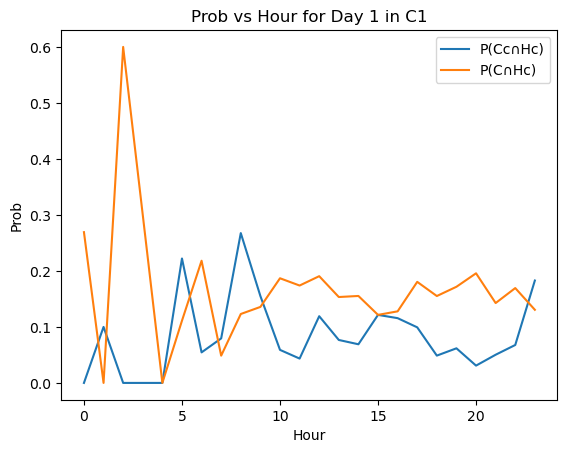

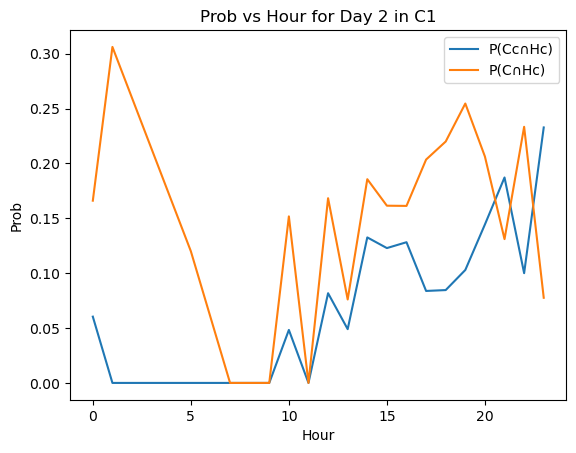

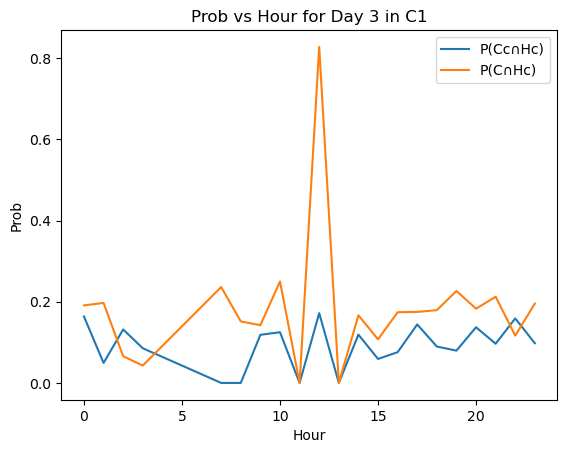

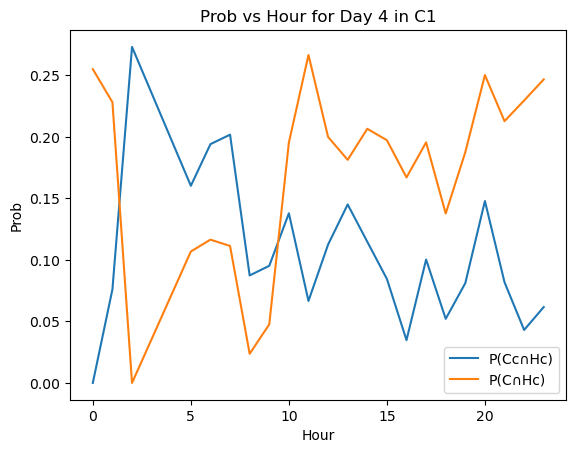

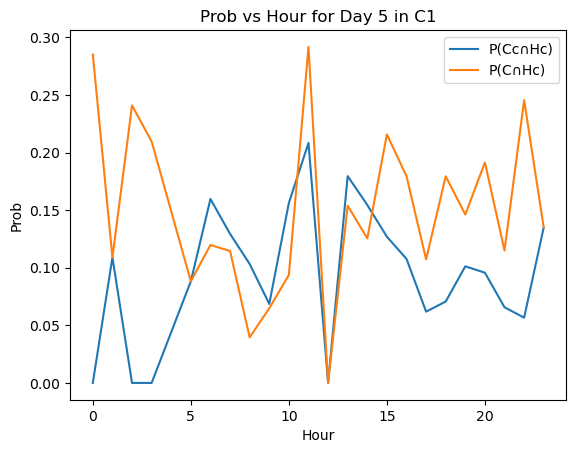

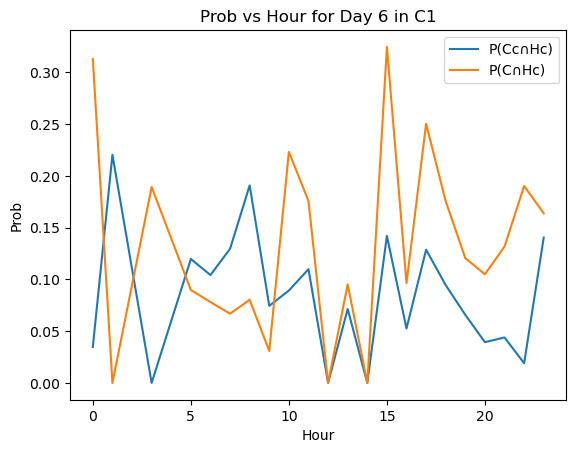

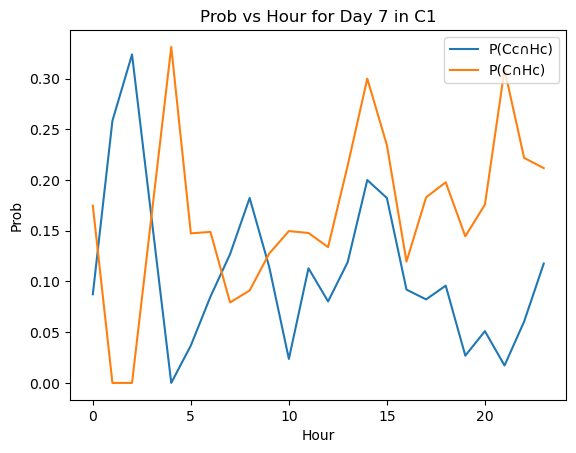

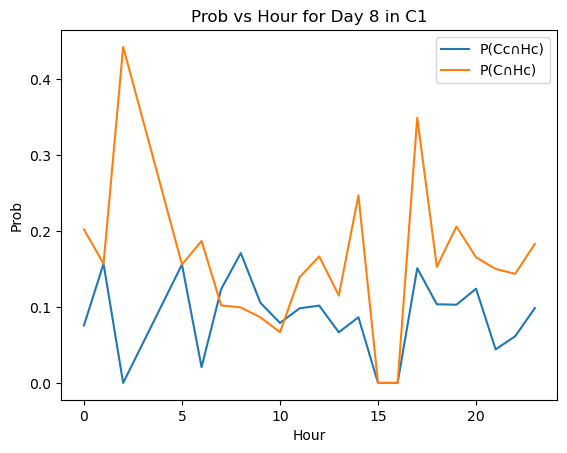

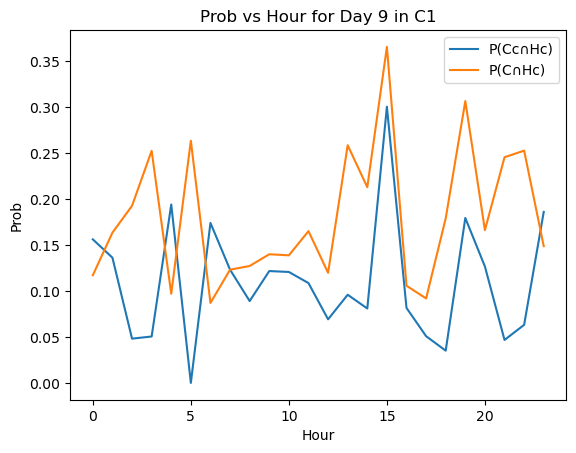

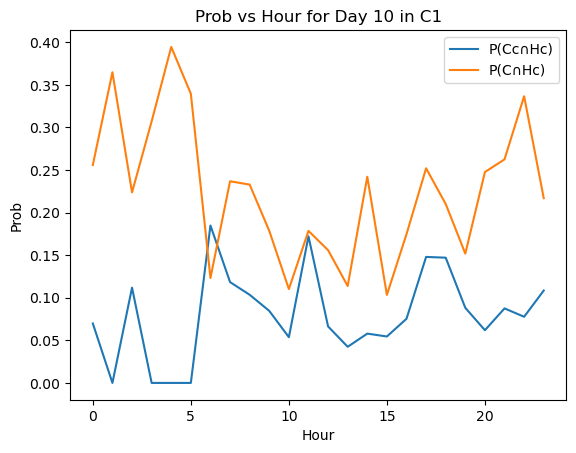

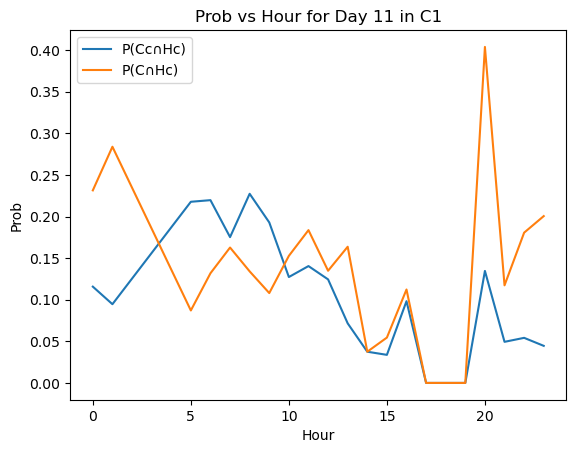

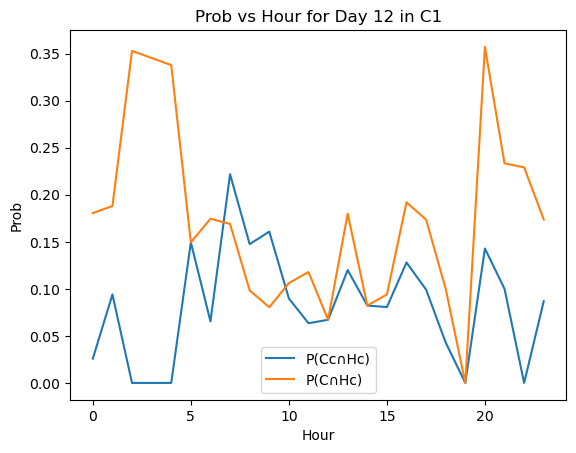

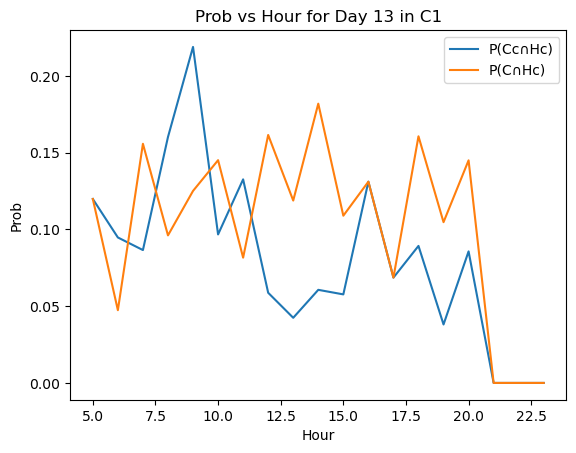

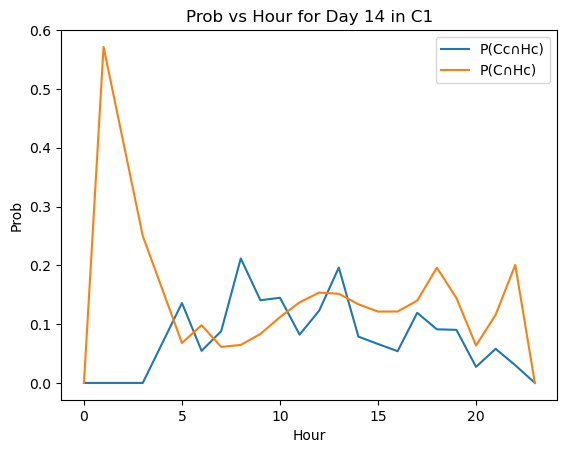

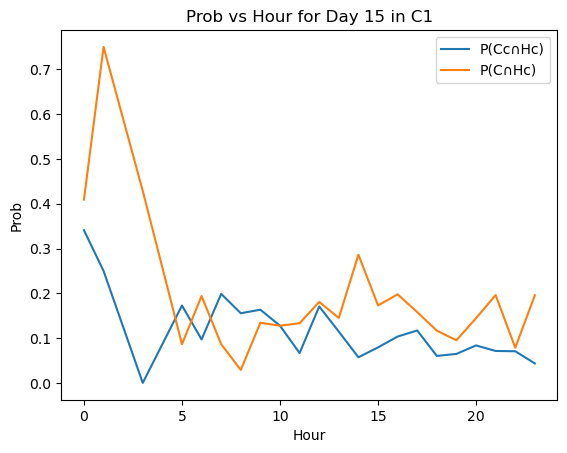

In [40]:
# line graph
for day, group in prob_c1.groupby('day'):
    fig, ax = plt.subplots()
    group = group.sort_values(by='start_hour') 
    plt.plot(group['start_hour'], group['P(Cc∩Hc)'], label='P(Cc∩Hc)')
    plt.plot(group['start_hour'], group['P(C∩Hc)'], label='P(C∩Hc)')
    plt.legend()
    plt.xlabel('Hour')
    plt.ylabel('Prob')
    plt.title(f'Prob vs Hour for Day {day} in C1')

# Show the plot
plt.show()

In [41]:
# check imbalances
display(pd.crosstab(index=c1['weather'], columns='count'))
display(pd.crosstab(index=c2['weather'], columns='count'))
display(pd.crosstab(index=c3['weather'], columns='count'))

col_0,count
weather,
haze,11
rainy,14
sunny,331


col_0,count
weather,
haze,11
rainy,15
sunny,334


col_0,count
weather,
haze,11
rainy,15
sunny,334


In [42]:
demand_all = demand_agg.groupby(['day','hour','weekday']).agg({'demand':'sum'}).reset_index().merge(mete_df, how='left',on=['day','hour'])
demand_all['isweekend'] = demand_all['weekday'].map(lambda x:x>4)
demand_all

,day,hour,weekday,demand,year,month,Temperature ° F,Wind Speed mph,weather,isweekend
0,1,0,4,393,2014,8,73.9,3.50,sunny,False
1,1,1,4,171,2014,8,73.0,3.50,sunny,False
2,1,2,4,126,2014,8,72.0,3.50,sunny,False
3,1,3,4,53,2014,8,72.0,3.50,sunny,False
4,1,4,4,69,2014,8,71.1,4.60,sunny,False
...,...,...,...,...,...,...,...,...,...,...
355,15,19,4,1900,2014,8,69.1,9.20,sunny,False
356,15,20,4,1217,2014,8,69.1,6.90,sunny,False
357,15,21,4,882,2014,8,69.1,4.60,sunny,False
358,15,22,4,769,2014,8,68.0,4.05,sunny,False


In [43]:
# define X and y
y = demand_all['demand']
X = demand_all.drop(columns=['demand','month','year','isweekend'])

# add dummy var
# col=list(X.select_dtypes(include=['bool']).columns)
# X = pd.get_dummies(X, columns = col,dtype='int',drop_first=True)
dummy_weather = pd.get_dummies(demand_all['weather'], columns=['sunny', 'rainy', 'haze'],dtype='int')
X = pd.concat([X.drop(columns='weather'), dummy_weather.drop(columns='sunny')], axis=1)

<Axes: >

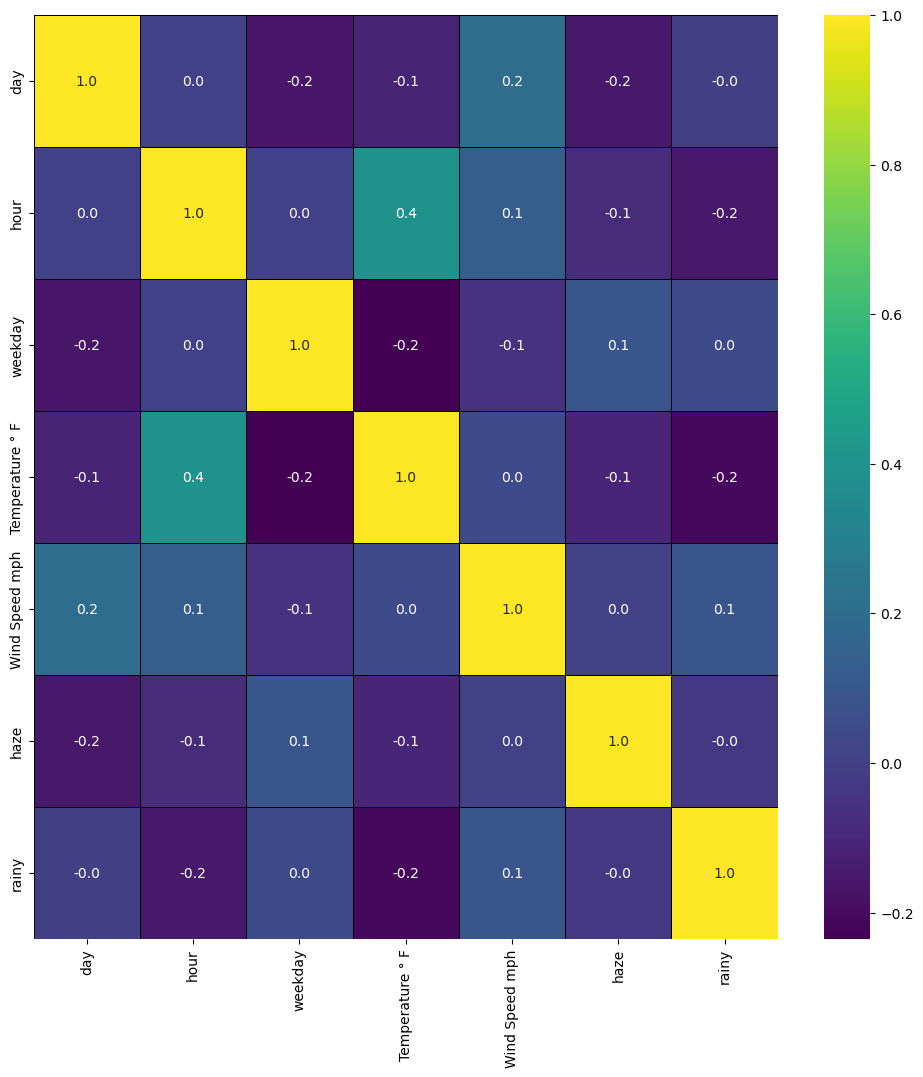

In [44]:
# corr plot
c = X.corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(12,12))         # Sample figsize in inches
sns.heatmap(c,cmap="viridis", annot=True, linewidths=.5, ax=ax,fmt='.1f',linecolor ='black')

In [45]:
# adding interaction and polynomial terms
X.loc[:,'Wind Speed mph'] = X['Wind Speed mph']
X.loc[:,'(Temperature*hour)^2'] = (X['Temperature ° F']*X['hour'])**2
# X.loc[:,'Temperature*rainy'] = (X['Temperature ° F']*X['rainy'])**2
# X.loc[:,'Temperature*haze'] = X['Temperature ° F']*X['haze']
# X.loc[:,'hour*Wind Speed mph'] = (X['hour']*X['Wind Speed mph'])**2
# X.loc[:,'(Temperature*haze)^2'] = (X['Temperature ° F']*X['haze'])**2

In [46]:
# x
X = X.drop(columns=['day','weekday'])

In [47]:
# Regression

# Add constant
X_lm = add_constant(X) # Add a column of ones to an dataset (intercept)

# Run regression
regression = sm.OLS(np.log(y),X_lm)
model = regression.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     121.8
Date:                Fri, 05 Apr 2024   Prob (F-statistic):           7.35e-83
Time:                        04:59:49   Log-Likelihood:                -414.23
No. Observations:                 360   AIC:                             842.5
Df Residuals:                     353   BIC:                             869.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.7992 

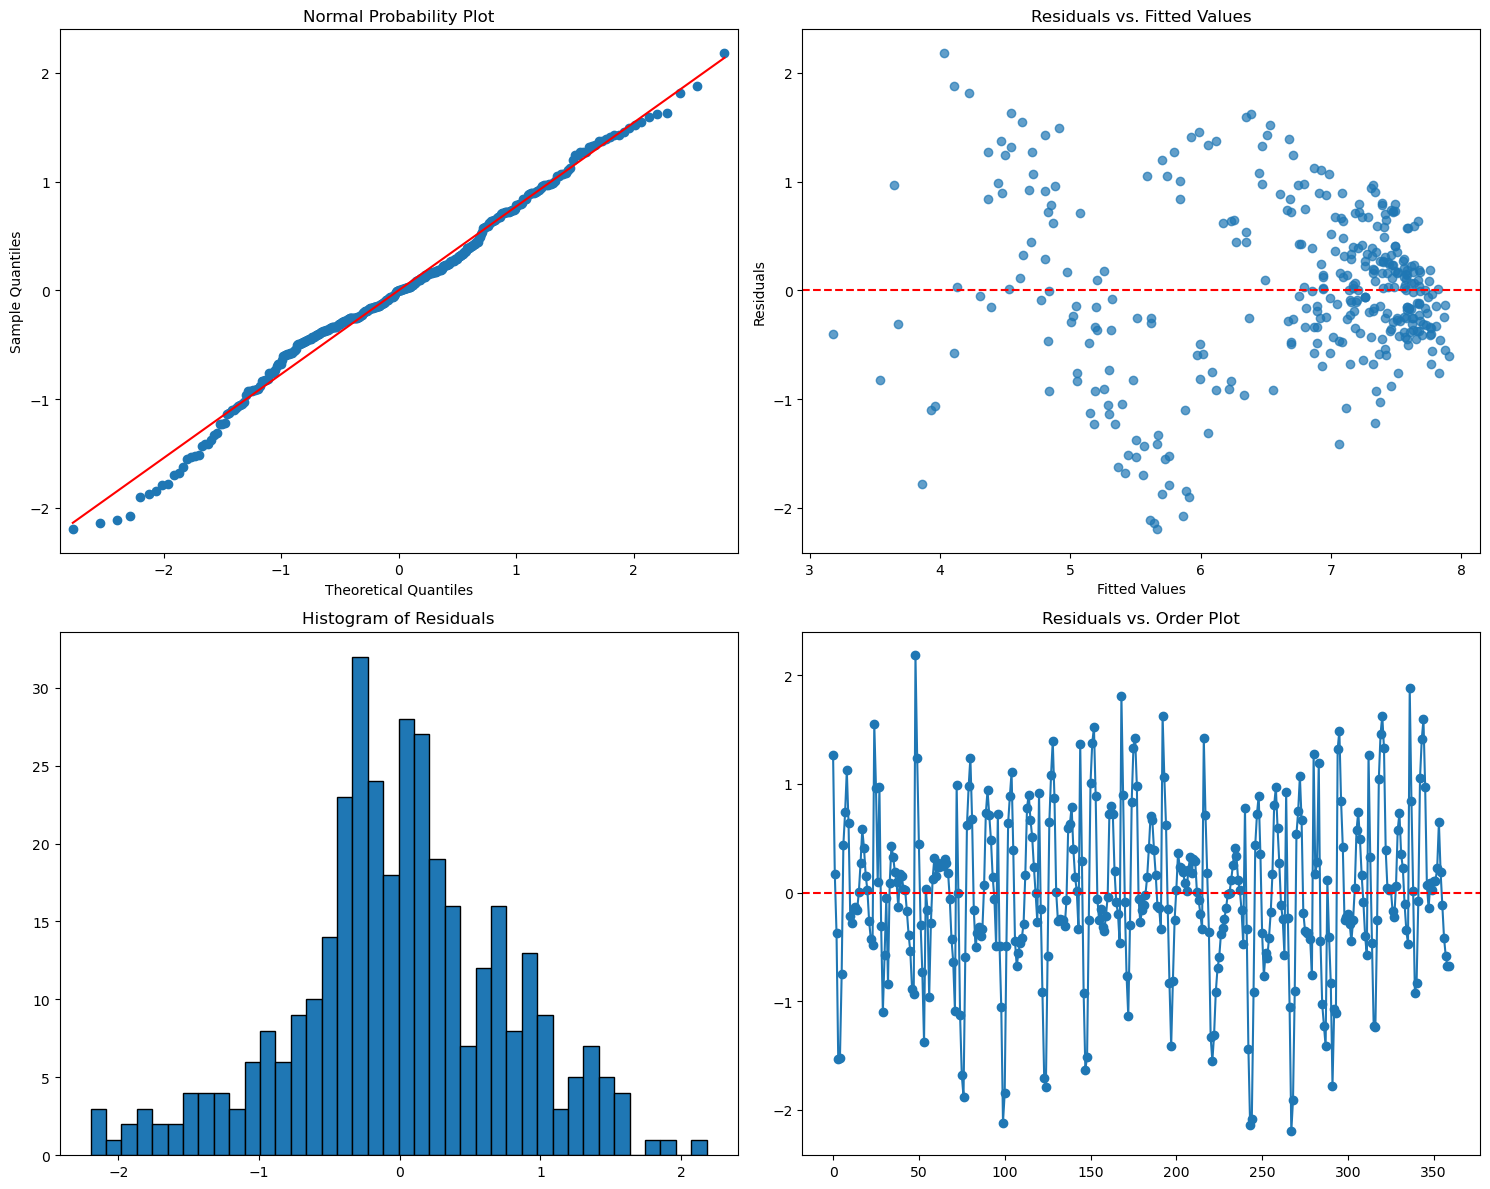

In [48]:
# Four in one plot

# Residuals vs. Fitted Values Plot
fig, ax = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Normal Probability Plot
sm.qqplot(model.resid, line='r', ax=ax[0, 0])
ax[0, 0].set_title('Normal Probability Plot')

# Plot 2: Residuals vs. Fitted Values
ax[0, 1].scatter(model.fittedvalues, model.resid, alpha=0.7)
ax[0, 1].axhline(y=0, color='r', linestyle='--')
ax[0, 1].set_title('Residuals vs. Fitted Values')
ax[0, 1].set_xlabel('Fitted Values')
ax[0, 1].set_ylabel('Residuals')


# Plot 3: Histogram of Residuals
ax[1, 0].hist(model.resid, bins=40, edgecolor='black')
ax[1, 0].set_title('Histogram of Residuals')

# Plot 4: Residuals vs. Order Plot
ax[1, 1].plot(range(len(model.resid)), model.resid, 'o', linestyle='-')
ax[1, 1].axhline(y=0, color='r', linestyle='--')
ax[1, 1].set_title('Residuals vs. Order Plot')

plt.tight_layout()
plt.show()

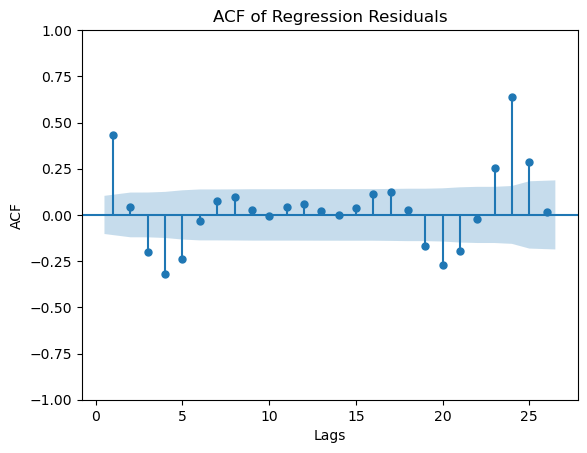

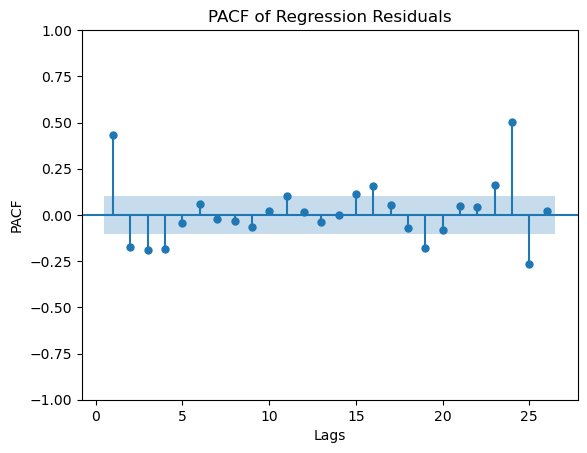

In [49]:
# ACF on residuals
plot_acf(np.exp(model.resid), zero=False, title='ACF of Regression Residuals')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()

plot_pacf(np.exp(model.resid), zero=False, title='PACF of Regression Residuals')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()

In [50]:
# Extract the series from the regression residuals
resid_series = pd.Series(np.exp(model.resid.values))
resid_series

0      3.556127
1      1.187365
2      0.691549
3      0.215681
4      0.217881
         ...   
355    0.892960
356    0.656633
357    0.557322
358    0.506711
359    0.509852
Length: 360, dtype: float64

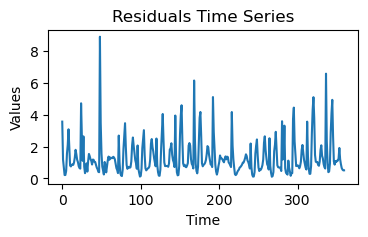

In [51]:
# Plot residuals time series
plt.figure(figsize=(4, 2))
plt.plot(resid_series)
plt.title('Residuals Time Series')
plt.xlabel('Time')
plt.ylabel('Values')
plt.show()

In [52]:
result = seasonal_decompose(resid_series, model='additive', period=24)
seasonal_component = result.seasonal
deseasonalized_data = resid_series-seasonal_component

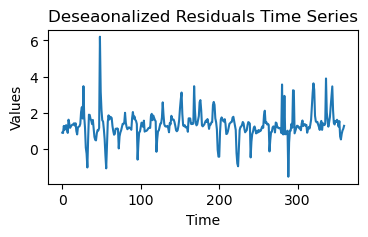

In [53]:
# Plot residuals time series
# first difference
plt.figure(figsize=(4, 2))
plt.plot(deseasonalized_data)
plt.title('Deseaonalized Residuals Time Series')
plt.xlabel('Time')
plt.ylabel('Values')
plt.show()

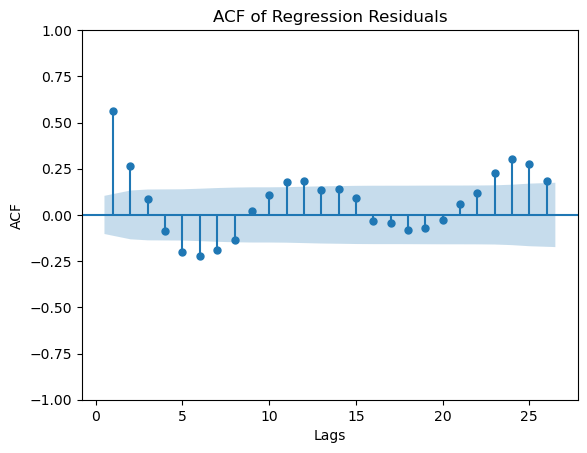

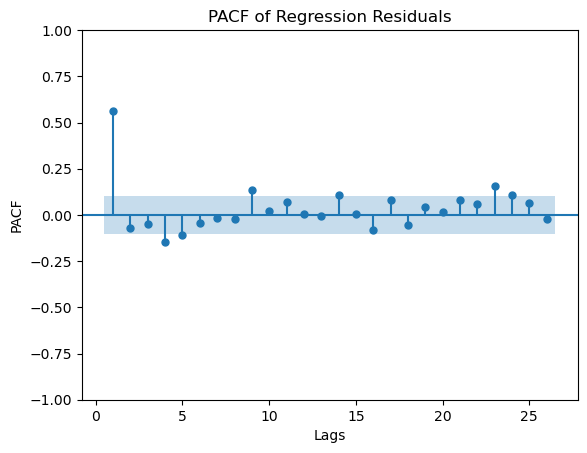

In [54]:
# ACF on deseasonalized residuals
plot_acf(deseasonalized_data, zero=False, title='ACF of Regression Residuals')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()

plot_pacf(deseasonalized_data, zero=False, title='PACF of Regression Residuals')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()

In [55]:
# Fit auto-ARIMA model
model_auto = auto_arima(deseasonalized_data,seasonal=True, m=4)
print(model_auto.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  360
Model:             SARIMAX(2, 0, 1)x(0, 0, [1, 2], 4)   Log Likelihood                -324.096
Date:                                Fri, 05 Apr 2024   AIC                            662.192
Time:                                        04:59:58   BIC                            689.395
Sample:                                             0   HQIC                           673.009
                                                - 360                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2711      0.196      1.383      0.167      -0.113       0.655
ar.

In [56]:
# Storing the predicted values
resid_pred = model_auto.predict_in_sample()

# Concating the predicted values to obtain the full prediction of the complete model
complete_pred = np.exp(model.fittedvalues)+(resid_pred+seasonal_component)

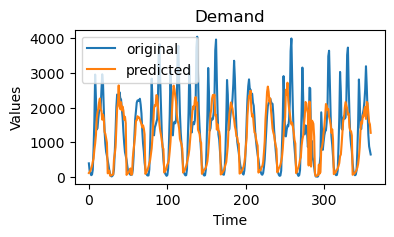

In [57]:
# Plot residuals time series
plt.figure(figsize=(4, 2))
plt.plot(y, label='original')
plt.plot(complete_pred, label='predicted')
plt.title('Demand')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

In [58]:
# defining functions of different metrics for assessing performance

def mad(yhat, y):
    return np.mean(np.abs(yhat - y))

def mse(yhat, y):
    return np.mean((yhat - y)**2)

def smape(yhat, y):
    return np.sum(abs(yhat - y)/((abs(yhat) + abs(y))/2)) / len(y) * 100

In [59]:
# Output displays

arima_output = {
    'The Complete Model': {
        'MAD': mad(complete_pred.values,y),
        'MSE': mse(complete_pred.values,y),
        'SMAPE': smape(complete_pred.values,y)
    }
}

pd.DataFrame.from_dict(arima_output, orient='index')

,MAD,MSE,SMAPE
The Complete Model,522.815662,569612.324098,53.077542


In [60]:
# MR model prediction
X_lm_pred = add_constant(X.loc[192:,:])
y_pred = model.predict(X_lm_pred)

# ARIMA preidiction
ARIMA_pred, conf_int = model_auto.predict(n_periods=len(X_lm_pred), return_conf_int=True)

# complete prediction
out_complete_pred = np.exp(y_pred).reset_index(drop=True)+(ARIMA_pred.reset_index(drop=True)+seasonal_component[:168].reset_index(drop=True))

In [61]:
demand_series = pd.Series(y.values, index=pd.date_range(start='2014-08-01 0:00', end='2014-08-15 23:00', freq='H'))
demand_series

2014-08-01 00:00:00     393
2014-08-01 01:00:00     171
2014-08-01 02:00:00     126
2014-08-01 03:00:00      53
2014-08-01 04:00:00      69
                       ... 
2014-08-15 19:00:00    1900
2014-08-15 20:00:00    1217
2014-08-15 21:00:00     882
2014-08-15 22:00:00     769
2014-08-15 23:00:00     648
Freq: H, Length: 360, dtype: int64

In [62]:
fitted_series = pd.Series(complete_pred.values, index=pd.date_range(start='2014-08-01 0:00', end='2014-08-15 23:00', freq='H'))
pred_series = pd.Series(out_complete_pred.values, index=pd.date_range('2014-08-16 0:00', end='2014-08-22 23:00', freq='H'))

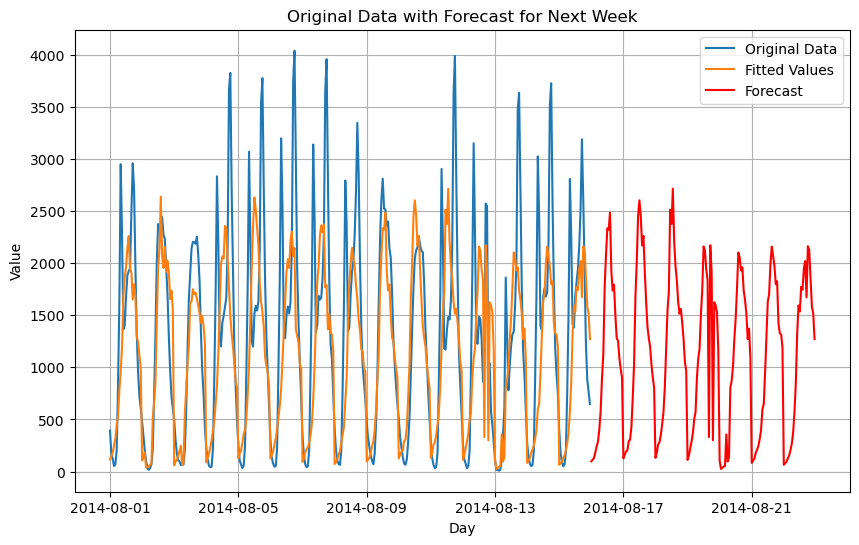

In [63]:
plt.figure(figsize=(10, 6))
plt.plot(demand_series.index, demand_series, label='Original Data')
plt.plot(fitted_series.index, fitted_series, label='Fitted Values')
plt.plot(pred_series.index, pred_series, label='Forecast', color='red')
plt.title('Original Data with Forecast for Next Week')
plt.xlabel('Day')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [64]:
prob_c1_processed = prob_c1.copy()
new_data = []  # to store modified rows
for day, group in prob_c1_processed.groupby('day'):
    group['hour_diff'] = group['start_hour'].diff()
    for i in range(len(group)):
        if i > 0 and group.iloc[i]['hour_diff'] > 1:
            num_missing_rows = int(group.iloc[i]['hour_diff']) - 1
            for _ in range(num_missing_rows):
                new_row = {
                    'day': day,
                    'weekday': group.iloc[i-1]['weekday'],
                    'start_hour': group.iloc[i-1]['start_hour'] + 1,
                    'P(Cc|H)': None,
                    'P(C∩H)': None,
                    'P(Cc∩H)': None,
                    'P(Cc|Hc)': None,
                    'P(C∩Hc)': None,
                    'P(Cc∩Hc)': None,
                    'isweekend': None
                }
                new_data.append(new_row)
        new_data.append(group.iloc[i].to_dict())

# Concatenate the original dataframe with the new_data
new_df = pd.DataFrame(new_data)

In [65]:
empty_rows = pd.DataFrame(columns=['day', 'weekday', 'start_hour', 'P(Cc|H)', 'P(C∩H)', 'P(Cc∩H)', 'P(Cc|Hc)', 'P(C∩Hc)', 'P(Cc∩Hc)', 'isweekend'])

# Add four empty rows with NaN values
for _ in range(3):
    empty_rows.loc[len(empty_rows)] = [None] * len(empty_rows.columns)
empty_rows.loc[:,'day']=[13]*3

In [66]:
# store processed frame
prob_c1_processed = pd.concat([new_df.loc[:287,:],empty_rows,new_df.loc[287:,:]]).reset_index(drop=True)

In [67]:
# fill NaN: interpolate
columns_to_fill = ['P(Cc|H)', 'P(C∩H)', 'P(Cc∩H)', 'P(Cc|Hc)', 'P(C∩Hc)', 'P(Cc∩Hc)']

# Apply linear interpolation to the subset columns
prob_c1_processed[columns_to_fill] = prob_c1_processed[columns_to_fill].interpolate(method='linear', axis=0)
prob_c1_processed

,day,weekday,start_hour,P(Cc|H),P(C∩H),P(Cc∩H),P(Cc|Hc),P(C∩Hc),P(Cc∩Hc),isweekend,hour_diff
0,1,4,0,0.263158,0.538462,0.192308,0.000000,0.269231,0.000000,False,NaN
1,1,4,1,0.555556,0.400000,0.500000,1.000000,0.000000,0.100000,False,1.0
2,1,4,2,0.750000,0.100000,0.300000,0.000000,0.600000,0.000000,False,1.0
3,1,4,3,0.375000,0.383333,0.150000,0.500000,0.300000,0.000000,None,NaN
4,1,4,4,0.000000,0.666667,0.000000,1.000000,0.000000,0.000000,False,2.0
...,...,...,...,...,...,...,...,...,...,...,...
354,15,4,19,0.155340,0.655617,0.120573,0.404762,0.095238,0.064762,False,1.0
355,15,4,20,0.213115,0.589040,0.159532,0.366667,0.144565,0.083696,False,1.0
356,15,4,21,0.160714,0.596182,0.114163,0.266667,0.196124,0.071318,False,1.0
357,15,4,22,0.240741,0.508954,0.161376,0.473684,0.078555,0.070699,False,1.0


In [68]:
prob_series = pd.Series(prob_c2['P(C∩H)'].values, index=pd.date_range(start='2014-08-01 1:00', end='2014-08-15 23:00', freq='H'))
prob_series

2014-08-01 01:00:00    0.633136
2014-08-01 02:00:00    0.689189
2014-08-01 03:00:00    0.666667
2014-08-01 04:00:00    0.700000
2014-08-01 05:00:00    0.538462
                         ...   
2014-08-15 19:00:00    0.536249
2014-08-15 20:00:00    0.533457
2014-08-15 21:00:00    0.562334
2014-08-15 22:00:00    0.510511
2014-08-15 23:00:00    0.604651
Freq: H, Length: 359, dtype: float64

In [69]:
# ETS model
model_ETS = ETSModel(prob_series, trend='add', seasonal='additive').fit()
print(model_ETS.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                  359
Model:                       ETS(AAA)   Log Likelihood                 523.061
Date:                Fri, 05 Apr 2024   AIC                           -986.121
Time:                        04:59:58   BIC                           -869.622
Sample:                    08-01-2014   HQIC                          -939.794
                         - 08-15-2014   Scale                            0.003
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.1870      0.032      5.869      0.000       0.125       0.250
smoothing_trend       1.87e-05        nan        nan        nan         nan         nan
smoothing_season

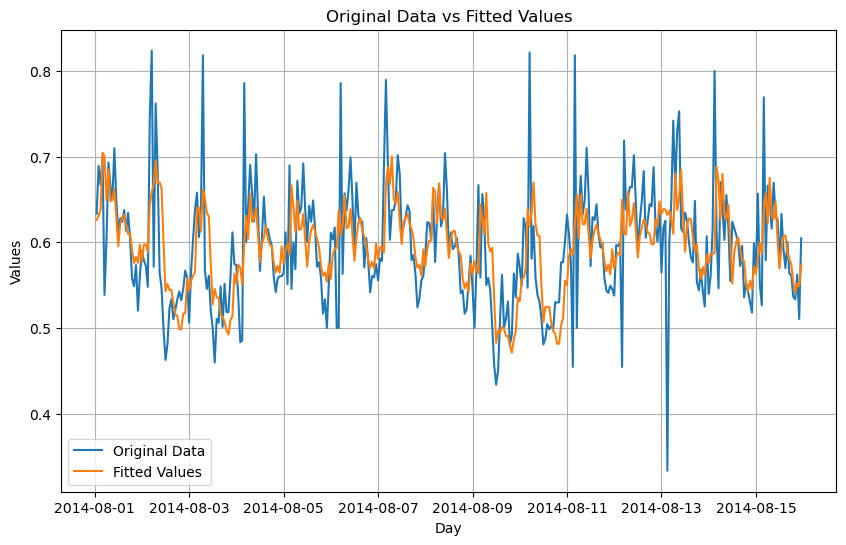

In [70]:
# Plotting original data and fitted values
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.plot(prob_series.index, prob_series, label='Original Data')
plt.plot(prob_series.index, model_ETS.fittedvalues, label='Fitted Values')
plt.xlabel('Day')
plt.ylabel('Values')
plt.title('Original Data vs Fitted Values')
plt.legend()
plt.grid(True)
plt.show()

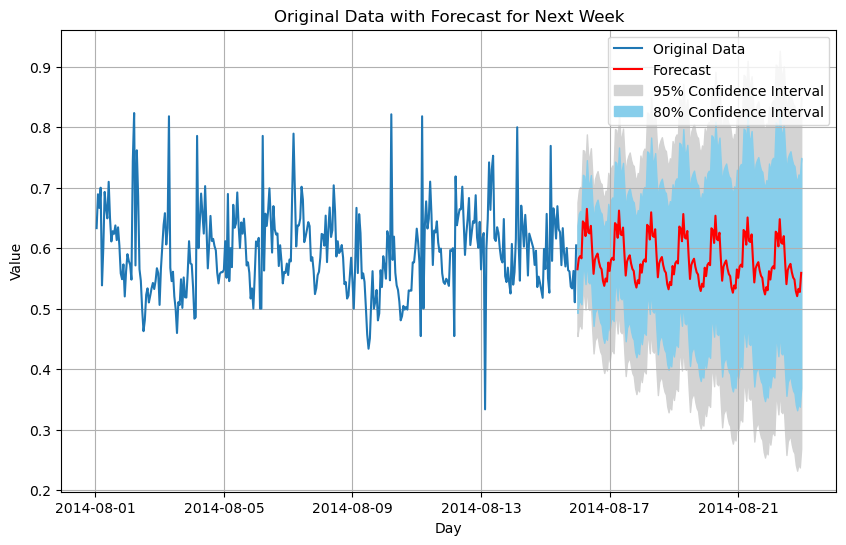

In [71]:
# Forecast for future years with confidence intervals
forecast_ETS = model_ETS.get_prediction(start='2014-08-16 0:00', end='2014-08-22 23:00')

ci_95 = forecast_ETS.summary_frame(alpha=0.05)
ci_80 = forecast_ETS.summary_frame(alpha=0.2)

plt.figure(figsize=(10, 6))
plt.plot(prob_series.index, prob_series, label='Original Data')
plt.plot(ci_95.index, ci_95['mean'], label='Forecast', color='red')
plt.fill_between(ci_95.index, ci_95['pi_lower'], ci_95['pi_upper'], color='lightgrey', label='95% Confidence Interval')
plt.fill_between(ci_80.index, ci_80['pi_lower'], ci_80['pi_upper'], color='skyblue', label='80% Confidence Interval')
plt.title('Original Data with Forecast for Next Week')
plt.xlabel('Day')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [72]:
# extract prob series

# c1
prob_c1_CH = pd.Series(prob_c1_processed['P(C∩H)'].values, index=pd.date_range(start='2014-08-01 1:00', end='2014-08-15 23:00', freq='H'))
prob_c1_CcH = pd.Series(prob_c1_processed['P(Cc∩H)'].values, index=pd.date_range(start='2014-08-01 1:00', end='2014-08-15 23:00', freq='H'))
prob_c1_CHc = pd.Series(prob_c1_processed['P(C∩Hc)'].values, index=pd.date_range(start='2014-08-01 1:00', end='2014-08-15 23:00', freq='H'))
prob_c1_CcHc= pd.Series(prob_c1_processed['P(Cc∩Hc)'].values, index=pd.date_range(start='2014-08-01 1:00', end='2014-08-15 23:00', freq='H'))

# c2
prob_c2_CH = pd.Series(prob_c2['P(C∩H)'].values, index=pd.date_range(start='2014-08-01 1:00', end='2014-08-15 23:00', freq='H'))
prob_c2_CcH = pd.Series(prob_c2['P(Cc∩H)'].values, index=pd.date_range(start='2014-08-01 1:00', end='2014-08-15 23:00', freq='H'))
prob_c2_CHc = pd.Series(prob_c2['P(C∩Hc)'].values, index=pd.date_range(start='2014-08-01 1:00', end='2014-08-15 23:00', freq='H'))
prob_c2_CcHc= pd.Series(prob_c2['P(Cc∩Hc)'].values, index=pd.date_range(start='2014-08-01 1:00', end='2014-08-15 23:00', freq='H'))

# c3
prob_c3_CH = pd.Series(prob_c2['P(C∩H)'].values, index=pd.date_range(start='2014-08-01 1:00', end='2014-08-15 23:00', freq='H'))
prob_c3_CcH = pd.Series(prob_c2['P(Cc∩H)'].values, index=pd.date_range(start='2014-08-01 1:00', end='2014-08-15 23:00', freq='H'))
prob_c3_CHc = pd.Series(prob_c2['P(C∩Hc)'].values, index=pd.date_range(start='2014-08-01 1:00', end='2014-08-15 23:00', freq='H'))
prob_c3_CcHc= pd.Series(prob_c2['P(Cc∩Hc)'].values, index=pd.date_range(start='2014-08-01 1:00', end='2014-08-15 23:00', freq='H'))

In [73]:
# model

# c1
model_ETS = ETSModel(prob_c1_CH, trend='add', seasonal='additive').fit()
forecast_ETS = model_ETS.get_prediction(start='2014-08-16 0:00', end='2014-08-22 23:00')
prob_c1_CH_pred = forecast_ETS.predicted_mean
model_ETS = ETSModel(prob_c1_CcH, trend='add', seasonal='additive').fit()
forecast_ETS = model_ETS.get_prediction(start='2014-08-16 0:00', end='2014-08-22 23:00')
prob_c1_CcH_pred = forecast_ETS.predicted_mean
model_ETS = ETSModel(prob_c1_CHc, trend='add', seasonal='additive').fit()
forecast_ETS = model_ETS.get_prediction(start='2014-08-16 0:00', end='2014-08-22 23:00')
prob_c1_CHc_pred = forecast_ETS.predicted_mean
model_ETS = ETSModel(prob_c1_CcHc, trend='add', seasonal='additive').fit()
forecast_ETS = model_ETS.get_prediction(start='2014-08-16 0:00', end='2014-08-22 23:00')
prob_c1_CcHc_pred = forecast_ETS.predicted_mean

# c2
model_ETS = ETSModel(prob_c2_CH, trend='add', seasonal='additive').fit()
forecast_ETS = model_ETS.get_prediction(start='2014-08-16 0:00', end='2014-08-22 23:00')
prob_c2_CH_pred = forecast_ETS.predicted_mean
model_ETS = ETSModel(prob_c2_CcH, trend='add', seasonal='additive').fit()
forecast_ETS = model_ETS.get_prediction(start='2014-08-16 0:00', end='2014-08-22 23:00')
prob_c2_CcH_pred = forecast_ETS.predicted_mean
model_ETS = ETSModel(prob_c2_CHc, trend='add', seasonal='additive').fit()
forecast_ETS = model_ETS.get_prediction(start='2014-08-16 0:00', end='2014-08-22 23:00')
prob_c2_CHc_pred = forecast_ETS.predicted_mean
model_ETS = ETSModel(prob_c2_CcHc, trend='add', seasonal='additive').fit()
forecast_ETS = model_ETS.get_prediction(start='2014-08-16 0:00', end='2014-08-22 23:00')
prob_c2_CcHc_pred = forecast_ETS.predicted_mean

# c3
model_ETS = ETSModel(prob_c3_CH, trend='add', seasonal='additive').fit()
forecast_ETS = model_ETS.get_prediction(start='2014-08-16 0:00', end='2014-08-22 23:00')
prob_c3_CH_pred = forecast_ETS.predicted_mean
model_ETS = ETSModel(prob_c3_CcH, trend='add', seasonal='additive').fit()
forecast_ETS = model_ETS.get_prediction(start='2014-08-16 0:00', end='2014-08-22 23:00')
prob_c3_CcH_pred = forecast_ETS.predicted_mean
model_ETS = ETSModel(prob_c3_CHc, trend='add', seasonal='additive').fit()
forecast_ETS = model_ETS.get_prediction(start='2014-08-16 0:00', end='2014-08-22 23:00')
prob_c3_CHc_pred = forecast_ETS.predicted_mean
model_ETS = ETSModel(prob_c3_CcHc, trend='add', seasonal='additive').fit()
forecast_ETS = model_ETS.get_prediction(start='2014-08-16 0:00', end='2014-08-22 23:00')
prob_c3_CcHc_pred = forecast_ETS.predicted_mean

In [74]:
# c1
percen_c1 = round(np.count_nonzero(labels == 0)/325,2)

In [75]:
# c2
percen_c2 = round(np.count_nonzero(labels == 1)/325,2)

In [76]:
# c3
percen_c3 = round(np.count_nonzero(labels == 2)/325,2)

In [77]:
parameter = {
    'demand':pred_series,
    'c1_P(C∩H)':prob_c1_CH_pred,
    'c1_P(Cc∩H)':prob_c1_CcH_pred,
    'c1_P(C∩Hc)':prob_c1_CHc_pred,
    'c1_P(Cc∩Hc)':prob_c1_CcHc_pred,
    'c1_C2∩Hc':[0.277908]*168,
    'c1_C3∩Hc':[0.72209]*168,
    'c1_C2∩H':[0.173576]*168,
    'c1_C3∩H':[0.826424]*168,
    'c2_P(C∩H)':prob_c2_CH_pred,
    'c2_P(Cc∩H)':prob_c2_CcH_pred,
    'c2_P(C∩Hc)':prob_c2_CHc_pred,
    'c2_P(Cc∩Hc)':prob_c2_CcHc_pred,
    'c2_C1∩Hc':[0.068892]*168,
    'c2_C3∩Hc':[0.931108]*168,
    'c2_C1∩H':[0.025516]*168,
    'c2_C3∩H':[0.974484]*168,
    'c3_P(C∩H)':prob_c3_CH_pred,
    'c3_P(Cc∩H)':prob_c3_CcH_pred,
    'c3_P(C∩Hc)':prob_c3_CHc_pred,
    'c3_P(Cc∩Hc)':prob_c3_CcHc_pred,
    'c3_C1∩Hc':[0.168746]*168,
    'c3_C2∩Hc':[0.831254]*168,
    'c3_C1∩H':[0.117484]*168,
    'c3_C2∩H':[0.882516]*168
}

param = pd.DataFrame.from_dict(parameter)
param

,demand,c1_P(C∩H),c1_P(Cc∩H),c1_P(C∩Hc),c1_P(Cc∩Hc),c1_C2∩Hc,c1_C3∩Hc,c1_C2∩H,c1_C3∩H,c2_P(C∩H),...,c2_C1∩H,c2_C3∩H,c3_P(C∩H),c3_P(Cc∩H),c3_P(C∩Hc),c3_P(Cc∩Hc),c3_C1∩Hc,c3_C2∩Hc,c3_C1∩H,c3_C2∩H
2014-08-16 00:00:00,97.885195,0.642483,0.138611,0.185293,0.128242,0.277908,0.72209,0.173576,0.826424,0.565150,...,0.025516,0.974484,0.565150,0.245540,0.089759,0.068015,0.168746,0.831254,0.117484,0.882516
2014-08-16 01:00:00,113.066767,0.696168,0.098561,0.283608,0.074906,0.277908,0.72209,0.173576,0.826424,0.583397,...,0.025516,0.974484,0.583397,0.244096,0.090333,0.068544,0.168746,0.831254,0.117484,0.882516
2014-08-16 02:00:00,130.709693,0.651782,0.160697,0.219278,0.100232,0.277908,0.72209,0.173576,0.826424,0.586924,...,0.025516,0.974484,0.586924,0.239993,0.099776,0.047602,0.168746,0.831254,0.117484,0.882516
2014-08-16 03:00:00,181.137403,0.708398,0.069205,0.245258,0.080536,0.277908,0.72209,0.173576,0.826424,0.583173,...,0.025516,0.974484,0.583173,0.206031,0.081173,0.103324,0.168746,0.831254,0.117484,0.882516
2014-08-16 04:00:00,240.565269,0.623699,0.128822,0.220114,0.065303,0.277908,0.72209,0.173576,0.826424,0.644304,...,0.025516,0.974484,0.644304,0.145700,0.089979,0.063102,0.168746,0.831254,0.117484,0.882516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-08-22 19:00:00,2129.456458,0.667348,0.079142,0.162495,0.084269,0.277908,0.72209,0.173576,0.826424,0.529216,...,0.025516,0.974484,0.529216,0.232228,-0.066519,0.091174,0.168746,0.831254,0.117484,0.882516
2014-08-22 20:00:00,1854.553025,0.695389,0.083668,0.165042,0.086196,0.277908,0.72209,0.173576,0.826424,0.520593,...,0.025516,0.974484,0.520593,0.250741,-0.070866,0.086875,0.168746,0.831254,0.117484,0.882516
2014-08-22 21:00:00,1583.442302,0.678572,0.096893,0.211098,0.104809,0.277908,0.72209,0.173576,0.826424,0.532705,...,0.025516,0.974484,0.532705,0.248249,-0.087619,0.081681,0.168746,0.831254,0.117484,0.882516
2014-08-22 22:00:00,1518.357663,0.691233,0.096096,0.183239,0.078506,0.277908,0.72209,0.173576,0.826424,0.527517,...,0.025516,0.974484,0.527517,0.233317,-0.067295,0.086748,0.168746,0.831254,0.117484,0.882516


In [78]:
cycle=param.copy().drop(columns='demand')

In [79]:
cycle.loc[:,'c1_P(C2∩H)']=cycle['c1_P(Cc∩H)']*cycle['c1_C2∩H']
cycle.loc[:,'c1_P(C3∩H)']=cycle['c1_P(Cc∩H)']*cycle['c1_C3∩H']
cycle.loc[:,'c1_P(C2∩Hc)']=cycle['c1_P(Cc∩Hc)']*cycle['c1_C2∩Hc']
cycle.loc[:,'c1_P(C3∩Hc)']=cycle['c1_P(Cc∩Hc)']*cycle['c1_C3∩Hc']

cycle.loc[:,'c2_P(C1∩H)']=cycle['c2_P(Cc∩H)']*cycle['c2_C1∩H']
cycle.loc[:,'c2_P(C3∩H)']=cycle['c2_P(Cc∩H)']*cycle['c2_C3∩H']
cycle.loc[:,'c2_P(C1∩Hc)']=cycle['c2_P(Cc∩Hc)']*cycle['c2_C1∩Hc']
cycle.loc[:,'c2_P(C3∩Hc)']=cycle['c2_P(Cc∩Hc)']*cycle['c2_C3∩Hc']

cycle.loc[:,'c3_P(C1∩H)']=cycle['c3_P(Cc∩H)']*cycle['c3_C1∩H']
cycle.loc[:,'c3_P(C2∩H)']=cycle['c3_P(Cc∩H)']*cycle['c3_C2∩H']
cycle.loc[:,'c3_P(C1∩Hc)']=cycle['c3_P(Cc∩Hc)']*cycle['c3_C1∩Hc']
cycle.loc[:,'c3_P(C2∩Hc)']=cycle['c3_P(Cc∩Hc)']*cycle['c3_C2∩Hc']

In [80]:
# import needed packages
import gurobipy as gp
from gurobipy import GRB

In [81]:
# extract demand for each cluster
demand_c1 = param['demand'].values*percen_c1
demand_c2 = param['demand'].values*percen_c2
demand_c3 = param['demand'].values*percen_c3
c1_C2_H = cycle['c1_P(C2∩H)'].values
c1_C3_H = cycle['c1_P(C3∩H)'].values
c1_C2_Hc = cycle['c1_P(C2∩Hc)'].values
c1_C3_Hc = cycle['c1_P(C3∩Hc)'].values
c1_C1_Hc = cycle['c1_P(C∩Hc)'].values
c1_C1_H = param['c1_P(C∩H)'].values
c1_C1_H = 1-c1_C2_H-c1_C3_H-c1_C2_Hc-c1_C3_Hc-c1_C1_Hc

c2_C1_H = cycle['c2_P(C1∩H)'].values
c2_C3_H = cycle['c2_P(C3∩H)'].values
c2_C1_Hc = cycle['c2_P(C1∩Hc)'].values
c2_C3_Hc = cycle['c2_P(C3∩Hc)'].values
c2_C2_Hc = cycle['c2_P(C∩Hc)'].values
c2_C2_H = param['c2_P(C∩H)'].values
c2_C2_H = 1-c2_C1_H-c2_C3_H-c2_C3_Hc-c2_C1_Hc-c2_C2_Hc

c3_C1_H = cycle['c3_P(C1∩H)'].values
c3_C2_H = cycle['c3_P(C2∩H)'].values
c3_C1_Hc = cycle['c3_P(C1∩Hc)'].values
c3_C2_Hc = cycle['c3_P(C2∩Hc)'].values
c3_C3_Hc = cycle['c3_P(C∩Hc)'].values
c3_C3_H = param['c3_P(C∩H)'].values
c3_C3_H = 1- c3_C1_H - c3_C2_H - c3_C1_Hc - c3_C2_Hc - c3_C3_Hc 

In [82]:
2000-(c1_C2_H[0]+c1_C3_H[0]+c1_C2_Hc[0]+c1_C3_Hc[0]+c1_C1_Hc[0])*1000+c2_C1_H[0]*500+c3_C1_H[0]*500

1565.4105130614535

In [83]:
# Initialize model
m = gp.Model()

# Decision variables
check_in = m.addVars(3, len(param), lb=0, name="check_in")
check_out = m.addVars(3, len(param), lb=0, name="check_out")
init_bike = m.addVars(3, lb=0, name="init_bike")
active_bike = m.addVars(3, len(param), lb=0, name="active_bike")

# Constraints

# Ensure check_out <= active_bike
for c in range(3):
    for h in range(len(param)):
        m.addConstr(check_out[c, h] <= active_bike[c, h])

# Ensure check_out <= demand
for h in range(len(param)):
    m.addConstr(check_out[0, h] <= demand_c1[h])
    m.addConstr(check_out[1, h] <= demand_c2[h])
    m.addConstr(check_out[2, h] <= demand_c3[h])

# Define check_in

# h=0
# c1
m.addConstr(check_in[0, 0] == c2_C1_H[0] * check_out[1, 0] + c3_C1_H[0] * check_out[2, 0] + c1_C1_H[0] * check_out[0, 0])
# c2
m.addConstr(check_in[1, 0] == c1_C2_H[0] * check_out[0, 0] + c3_C2_H[0] * check_out[2, 0] + c2_C2_H[0] * check_out[1, 0])
# c3
m.addConstr(check_in[2, 0] == c1_C3_H[0] * check_out[0, 0] + c2_C3_H[0] * check_out[1, 0] + c3_C3_H[0] * check_out[2, 0])

# 167>h>0
for h in range(1, len(param)-1):
    # c1
    m.addConstr(check_in[0, h] == c2_C1_H[h] * check_out[1, h] + c3_C1_H[h] * check_out[2, h] + c1_C1_H[h] * check_out[0, h]\
                + c2_C1_Hc[h - 1] * check_out[1, h - 1] + c3_C1_Hc[h - 1] * check_out[2, h - 1] + c1_C1_Hc[h - 1] * check_out[0, h - 1])
    # c2
    m.addConstr(check_in[1, h] == c1_C2_H[h] * check_out[0, h] + c3_C2_H[h] * check_out[2, h] + c2_C2_H[h] * check_out[1, h]\
                + c1_C2_Hc[h - 1] * check_out[0, h - 1] + c3_C2_Hc[h - 1] * check_out[2, h - 1] + c2_C2_Hc[h - 1] * check_out[1, h - 1])
    # c3
    m.addConstr(check_in[2, h] == c1_C3_H[h] * check_out[0, h] + c2_C3_H[h] * check_out[1, h] + c3_C3_H[h] * check_out[2, h]\
                + c1_C3_Hc[h - 1] * check_out[0, h - 1] + c2_C3_Hc[h - 1] * check_out[1, h - 1] + c3_C3_Hc[h - 1] * check_out[2, h - 1])

# h=167
# c1
m.addConstr(check_in[0, 167] == (c2_C1_H[167]+c2_C1_Hc[167]) * check_out[1, 167] + (c3_C1_H[167]+c3_C1_Hc[167]) * check_out[2, 167] + (c1_C1_H[167]+c1_C1_Hc[167]) * check_out[0, 167]\
            + c2_C1_Hc[166] * check_out[1, 166] + c3_C1_Hc[166] * check_out[2, 166] + c1_C1_Hc[166] * check_out[0, 166])
# c2
m.addConstr(check_in[1, 167] == (c1_C2_H[167]+c1_C2_Hc[167]) * check_out[0, 167] + (c3_C2_H[167]+c3_C2_Hc[167]) * check_out[2, 167] + (c2_C2_H[167]+c2_C2_Hc[167]) * check_out[1, 167]\
            + c1_C2_Hc[166] * check_out[0, 166] + c3_C2_Hc[166] * check_out[2, 166] + c2_C2_Hc[166] * check_out[1, 166])
# c3
m.addConstr(check_in[2, 167] == (c1_C3_H[167]+c1_C3_Hc[167]) * check_out[0, 167] + (c2_C3_H[167]+c2_C3_Hc[167]) * check_out[1, 167] + (c3_C3_H[167]+c3_C3_Hc[167]) * check_out[2, 167]\
            + c1_C3_Hc[166] * check_out[0, 166] + c2_C3_Hc[166] * check_out[1, 166] + c3_C3_Hc[166] * check_out[2, 166])

# Define active_bike

# h=0
for c in range(3):
    m.addConstr(active_bike[c, 0] == init_bike[c]+ check_in[c, 0] - check_out[c, 0])

# h>0
for c in range(3):
    for h in range(1, len(param)):
        m.addConstr(active_bike[c, h] == active_bike[c, h - 1] + check_in[c, h] - check_out[c, h])

# Objective function
m.setObjective(
    # Penalize the difference between demand and portion captured by check_out
    gp.quicksum(demand_c1[h] - check_out[0, h] for h in range(len(param))) +
    gp.quicksum(demand_c2[h] - check_out[1, h] for h in range(len(param))) +
    gp.quicksum(demand_c3[h] - check_out[2, h] for h in range(len(param))) +
    # Penalize the number of initial bikes
    6*gp.quicksum(init_bike[c] for c in range(3)),
    GRB.MINIMIZE
)

# Optimize
m.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-03
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: AMD Ryzen 7 6800HS with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 2016 rows, 1515 columns and 7047 nonzeros
Model fingerprint: 0x5e56e596
Coefficient statistics:
  Matrix range     [7e-05, 1e+00]
  Objective range  [1e+00, 6e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 1e+03]
Presolve removed 1269 rows and 765 columns
Presolve time: 0.01s
Presolved: 747 rows, 750 columns, 6038 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2577833e+01   1.017641e+05   0.000000e+00      0s
     249    4.3858235e+04   0.000000e+00   0.000000e+00      0s

Solved in 249 iterations and 0.03 seconds (0.01 work units)
Optimal objective  4.385823544e+04


In [84]:
c1_check_out = [0]*168
c2_check_out = [0]*168
c3_check_out = [0]*168
c1_check_in = [0]*168
c2_check_in = [0]*168
c3_check_in = [0]*168
c1_active_bike = [0]*168
c2_active_bike = [0]*168
c3_active_bike = [0]*168
init_bike_lt = [0]*3

for h in range(len(param)):
    c1_check_out[h] = check_out[0, h].X
    c2_check_out[h] = check_out[1, h].X
    c3_check_out[h] = check_out[2, h].X
    c1_check_in[h] = check_in[0, h].X
    c2_check_in[h] = check_in[1, h].X
    c3_check_in[h] = check_in[2, h].X
    c1_active_bike[h] = active_bike[0, h].X
    c2_active_bike[h] = active_bike[1, h].X
    c3_active_bike[h] = active_bike[2, h].X

for c in range(3):
    init_bike_lt[c] = init_bike[c].X
    
output_dict = {
    'c1_check_out':c1_check_out,
    'c2_check_out':c2_check_out,
    'c3_check_out':c3_check_out, 
    'c1_check_in':c1_check_in, 
    'c2_check_in':c2_check_in, 
    'c3_check_in':c3_check_in,
    'c1_active_bike':c1_active_bike,
    'c2_active_bike':c2_active_bike,
    'c3_active_bike':c3_active_bike
}

output_df = pd.DataFrame.from_dict(output_dict)

In [85]:
init_bike_lt

[1246.249712829049, 873.4405697004001, 534.0345463570375]

In [86]:
output_df

,c1_check_out,c2_check_out,c3_check_out,c1_check_in,c2_check_in,c3_check_in,c1_active_bike,c2_active_bike,c3_active_bike
0,23.492447,36.217522,38.175226,14.198592,30.447981,34.135623,1236.955858,867.671029,529.994943
1,27.136024,41.834704,44.096039,21.218778,41.186247,46.383627,1231.038612,867.022572,532.282531
2,31.370326,48.362586,50.976780,26.443127,48.156555,54.827562,1226.111413,866.816540,536.133313
3,43.472977,67.020839,70.643587,35.810411,61.930726,68.497949,1218.448847,861.726427,533.987674
4,57.735665,89.009150,93.820455,48.127016,88.250286,99.283298,1208.840198,860.967564,539.450517
...,...,...,...,...,...,...,...,...,...
163,185.260839,741.118345,830.488019,200.878632,758.011269,831.955231,185.260839,741.118345,1642.881516
164,193.641731,686.184619,723.275680,202.022623,683.987917,730.341726,193.641731,738.921643,1649.947562
165,185.470393,585.873652,617.542498,177.299055,590.565489,640.790183,185.470393,743.613480,1673.195247
166,188.540287,561.792335,592.159489,191.610182,540.860963,589.670392,188.540287,722.682107,1670.706151


In [87]:
sum(output_df['c1_check_out']+output_df['c2_check_out']+output_df['c3_check_out'])/sum(demand_c1+demand_c2+demand_c3)

0.8543879036320391

In [88]:
sum(output_df['c1_check_out'])/sum(demand_c1)

0.436392596605957

In [89]:
sum(init_bike_lt)

2653.7248288864866

In [90]:
sum(output_df[['c1_active_bike','c2_active_bike','c3_active_bike']].iloc[167,:])

2653.7248288864866

In [91]:
output_df[['c1_active_bike','c2_active_bike','c3_active_bike']].iloc[167,:]

c1_active_bike     227.457761
c2_active_bike     726.675652
c3_active_bike    1699.591415
Name: 167, dtype: float64

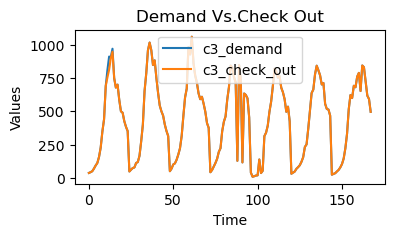

In [92]:
# Plot residuals time series
plt.figure(figsize=(4, 2))
plt.plot(demand_c3, label='c3_demand')
plt.plot(output_df['c3_check_out'], label='c3_check_out')

plt.title('Demand Vs.Check Out')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

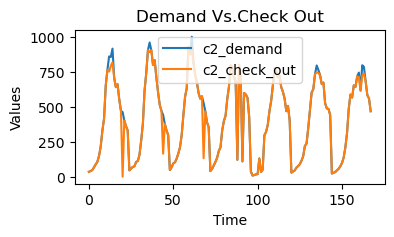

In [93]:
# Plot residuals time series
plt.figure(figsize=(4, 2))
plt.plot(demand_c2, label='c2_demand')
plt.plot(output_df['c2_check_out'], label='c2_check_out')

plt.title('Demand Vs.Check Out')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

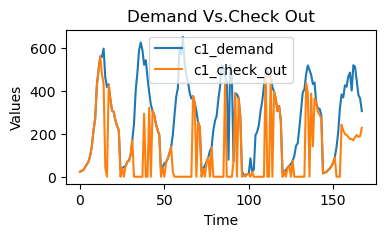

In [94]:
# Plot residuals time series
plt.figure(figsize=(4, 2))
plt.plot(demand_c1, label='c1_demand')
plt.plot(output_df['c1_check_out'], label='c1_check_out')

plt.title('Demand Vs.Check Out')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

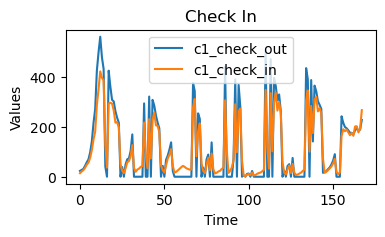

In [95]:
# Plot residuals time series
plt.figure(figsize=(4, 2))
plt.plot(output_df['c1_check_out'], label='c1_check_out')
plt.plot(output_df['c1_check_in'], label='c1_check_in')

plt.title('Check In')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

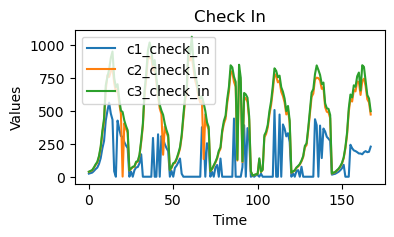

In [96]:
# Plot residuals time series
plt.figure(figsize=(4, 2))
plt.plot(output_df['c1_check_out'], label='c1_check_in')
plt.plot(output_df['c2_check_out'], label='c2_check_in')
plt.plot(output_df['c3_check_out'], label='c3_check_in')
plt.title('Check In')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

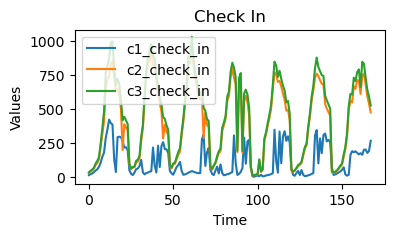

In [97]:
# Plot residuals time series
plt.figure(figsize=(4, 2))
plt.plot(output_df['c1_check_in'], label='c1_check_in')
plt.plot(output_df['c2_check_in'], label='c2_check_in')
plt.plot(output_df['c3_check_in'], label='c3_check_in')
plt.title('Check In')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

In [98]:

c1_series = pd.Series(output_df['c1_active_bike'].values, index=pd.date_range(start='2014-08-16 0:00', end='2014-08-22 23:00', freq='H'))
c2_series = pd.Series(output_df['c2_active_bike'].values, index=pd.date_range(start='2014-08-16 0:00', end='2014-08-22 23:00', freq='H'))
c3_series = pd.Series(output_df['c3_active_bike'].values, index=pd.date_range(start='2014-08-16 0:00', end='2014-08-22 23:00', freq='H'))


In [99]:
demand_c1_s = pd.Series(demand_c1,index=pd.date_range(start='2014-08-16 0:00', end='2014-08-22 23:00', freq='H'))
demand_c2_s = pd.Series(demand_c2,index=pd.date_range(start='2014-08-16 0:00', end='2014-08-22 23:00', freq='H'))
demand_c3_s = pd.Series(demand_c3,index=pd.date_range(start='2014-08-16 0:00', end='2014-08-22 23:00', freq='H'))

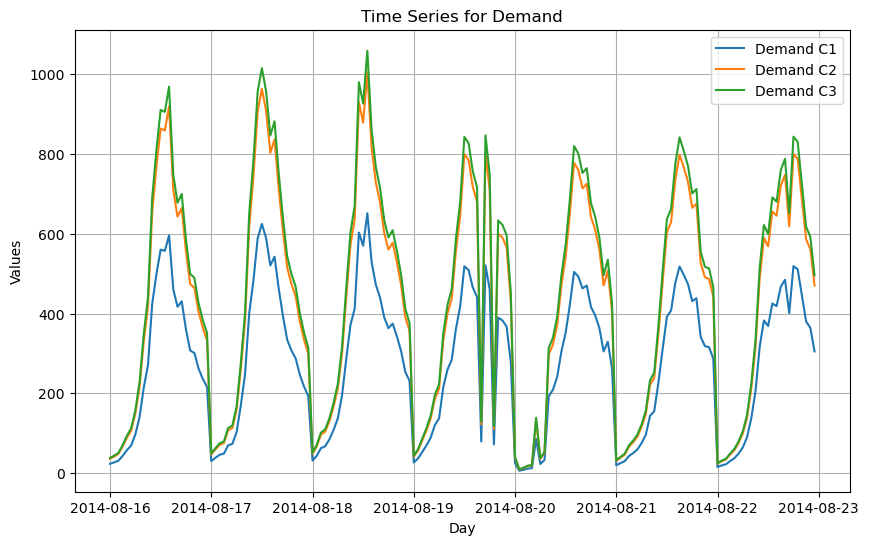

In [100]:

# Plotting original data and fitted values
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.plot(demand_c1_s.index, demand_c1_s, label='Demand C1')
plt.plot(demand_c1_s.index, demand_c2_s, label='Demand C2')
plt.plot(demand_c1_s.index, demand_c3_s, label='Demand C3')
plt.xlabel('Day')
plt.ylabel('Values')
plt.title('Time Series for Demand')
plt.legend()
plt.grid(True)
plt.show()

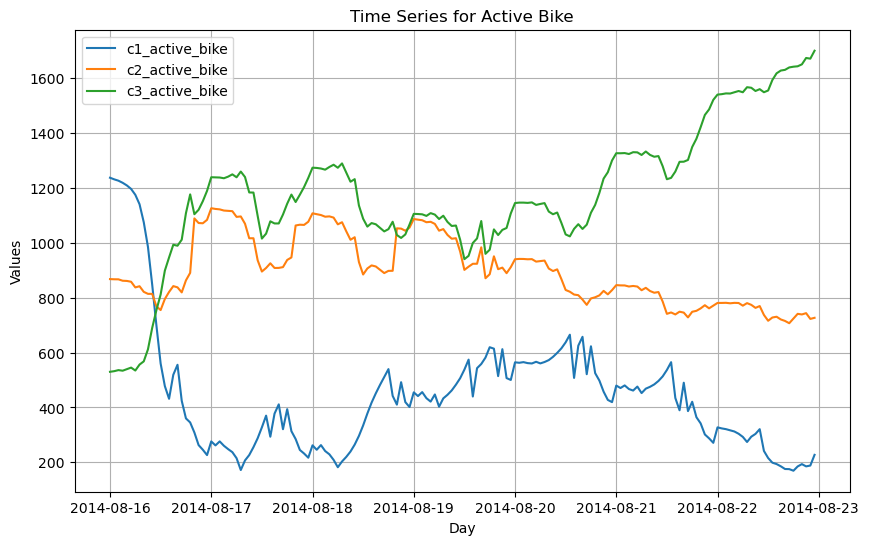

In [101]:
# Plotting original data and fitted values
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.plot(c1_series.index, c1_series, label='c1_active_bike')
plt.plot(c2_series.index, c2_series, label='c2_active_bike')
plt.plot(c3_series.index, c3_series, label='c3_active_bike')
plt.xlabel('Day')
plt.ylabel('Values')
plt.title('Time Series for Active Bike')
plt.legend()
plt.grid(True)
plt.show()

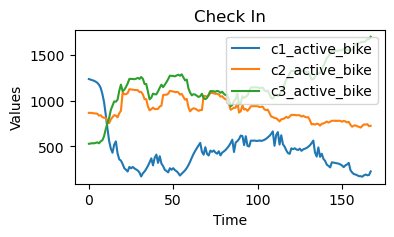

In [102]:
# Plot residuals time series
plt.figure(figsize=(4, 2))
plt.plot(output_df['c1_active_bike'], label='c1_active_bike')
plt.plot(output_df['c2_active_bike'], label='c2_active_bike')
plt.plot(output_df['c3_active_bike'], label='c3_active_bike')
plt.title('Check In')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

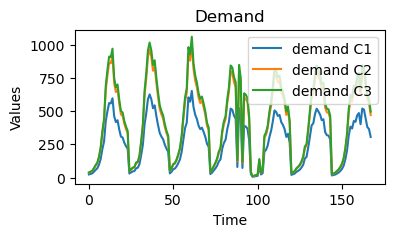

In [103]:
# Plot residuals time series
plt.figure(figsize=(4, 2))
plt.plot(demand_c1, label='demand C1')
plt.plot(demand_c2, label='demand C2')
plt.plot(demand_c3, label='demand C3')
plt.title('Demand')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

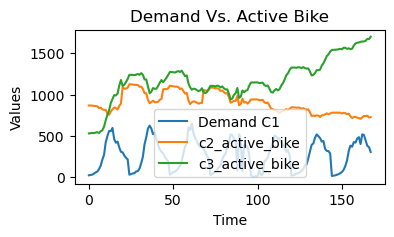

In [104]:
# Plot residuals time series
plt.figure(figsize=(4, 2))
plt.plot(demand_c1, label='Demand C1')
plt.plot(output_df['c2_active_bike'], label='c2_active_bike')
plt.plot(output_df['c3_active_bike'], label='c3_active_bike')
plt.title('Demand Vs. Active Bike')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()